<a href="https://colab.research.google.com/github/ostrowsky/Deep-Learning-School/blob/master/ostrowsky_hw_7_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

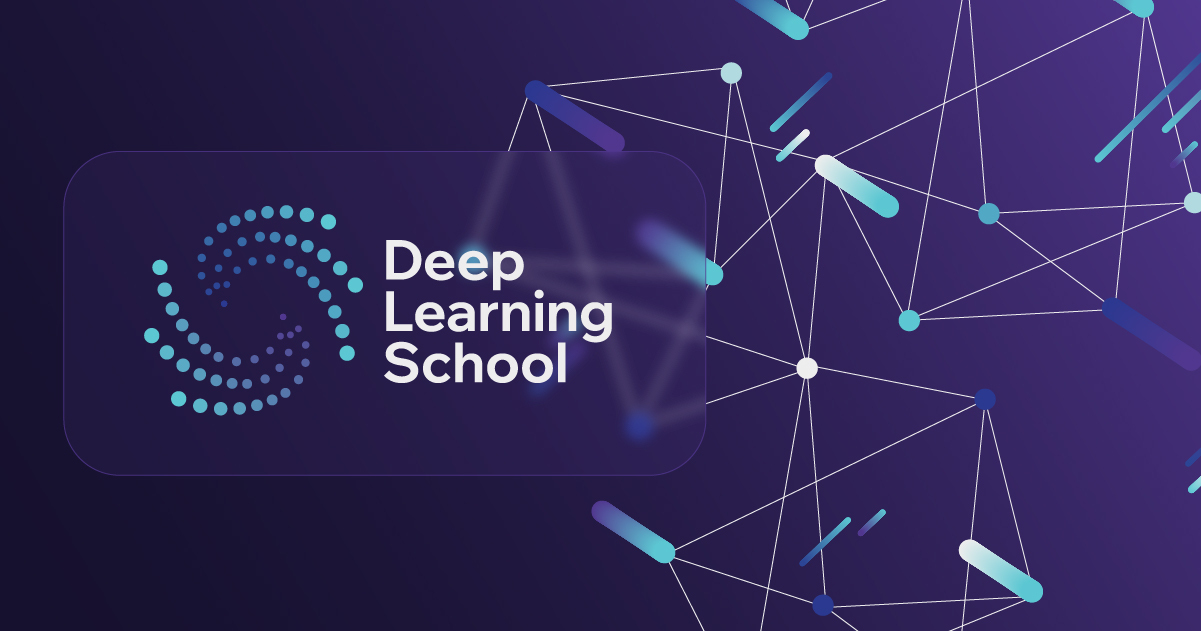


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

import tqdm
from tqdm import tqdm_notebook
%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [ ]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [ ]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [ ]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)

    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('float32')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [ ]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()



In [ ]:
images /= 255.

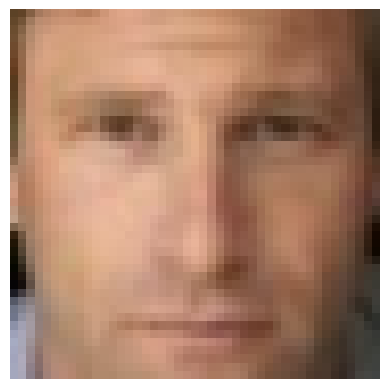

In [ ]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

In [ ]:
images = torch.from_numpy(images).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

In [ ]:
images.min(), images.max()

(tensor(0.), tensor(1.))


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_len = round(len(images)*0.80)
train_images, train_attrs = images[:train_len], attrs[:train_len]
val_images, val_attrs = images[train_len:], attrs[train_len:]


In [ ]:
print(len(train_images), len(train_attrs ), len(val_images), len(val_attrs))

10514 10514 2629 2629


## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



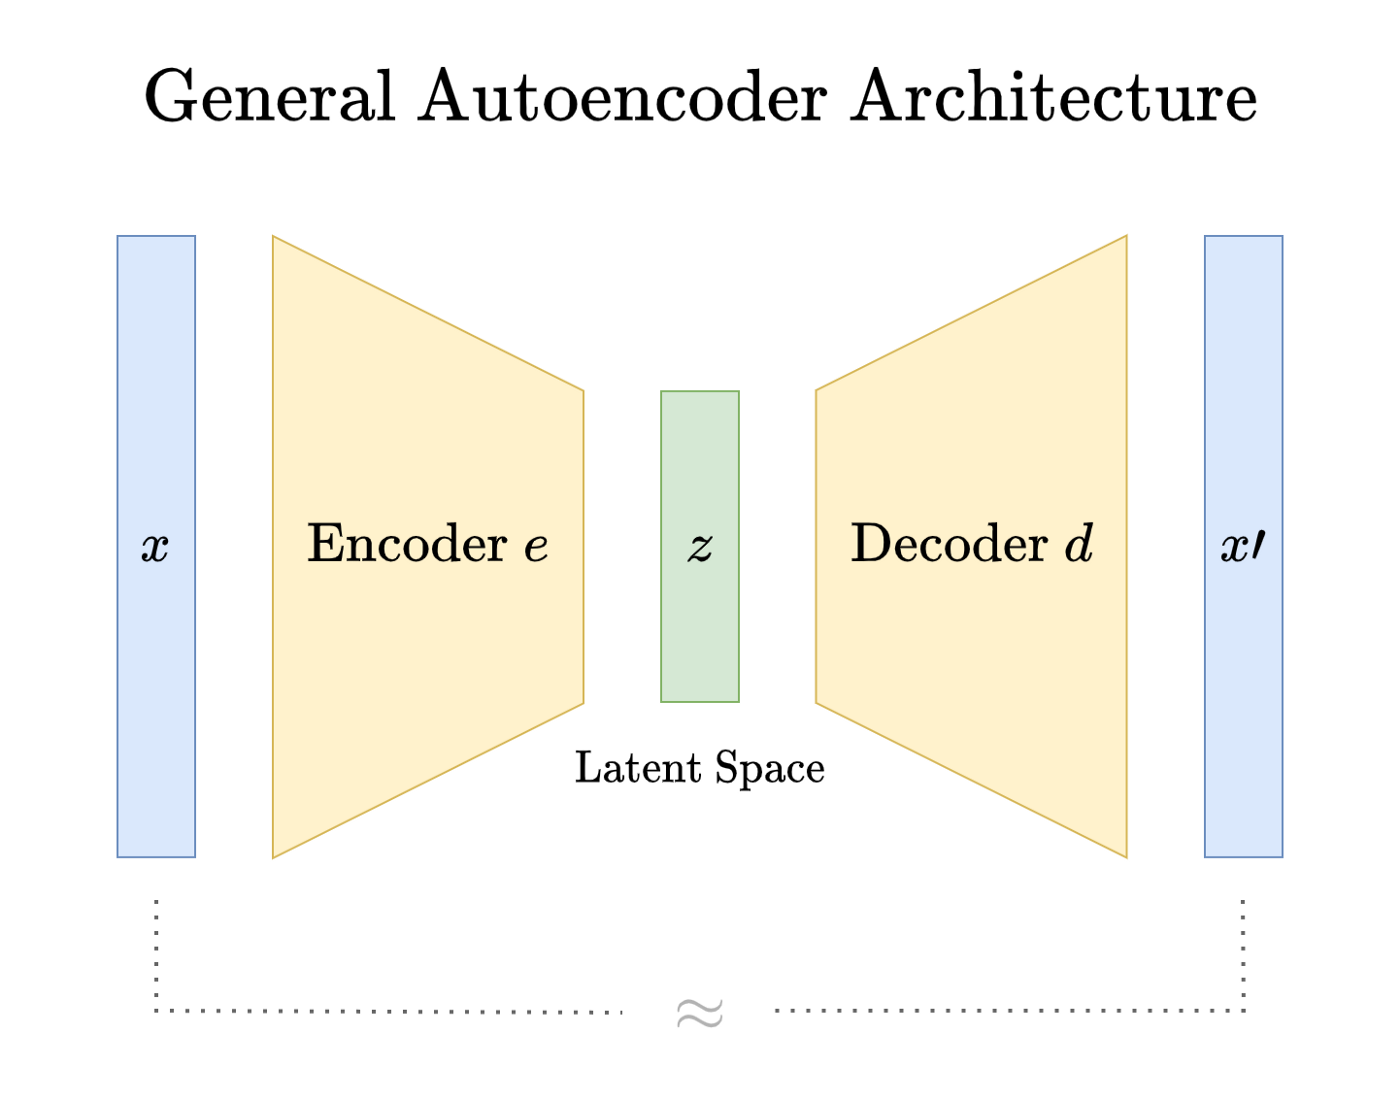

In [ ]:
#dim_code = 1296 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder>
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7), #42 -> 36
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16,  kernel_size=7), #36-> 30
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8,  kernel_size=7), #30 -> 24
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 4,  kernel_size=7) #24 -> 18
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=7),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, kernel_size=7),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 32, kernel_size=7),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=7),
            nn.Sigmoid()
)


    def forward(self, x):
        # реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

    def get_latent_vector(self, x):
        """
        Получает только латентный вектор из входного изображения

        Args:
            x: входное изображение

        Returns:
            latent_code: латентное представление изображения
        """
        with torch.no_grad():
            latent_code = self.encoder(x)
        return latent_code

    def generate_from_latent(self, latent_code):
        """
        Генерирует изображение из латентного представления

        Args:
            latent_code: латентное представление

        Returns:
            reconstruction: реконструированное изображение
        """
        with torch.no_grad():
            reconstruction = self.decoder(latent_code)
        return reconstruction



In [ ]:
n_epochs = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
loss_fn = F.mse_loss# <loss>
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# <Ваш любимый оптимизатор>

cuda:0


## 1.3 Обучение (2 балла)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_images, batch_size=4)
val_loader = torch.utils.data.DataLoader(val_images, batch_size=4)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
train_losses = []
val_losses = []


for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch = X_batch.float().to(device)
        reconstructed = model(X_batch)
        loss = loss_fn(reconstructed[0], X_batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed[0], X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-86-f823919c2e75>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

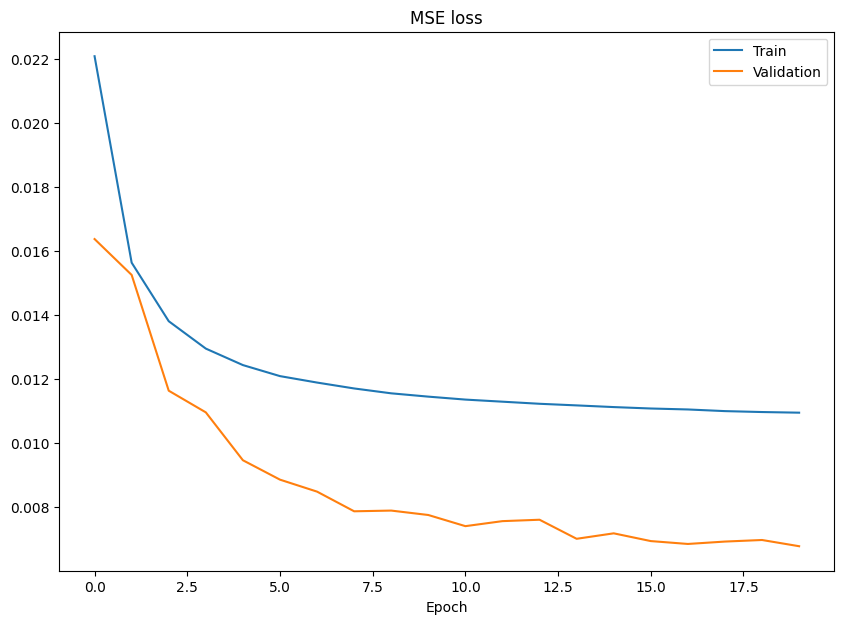

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')


plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

0.015686275 0.92156863 0.11151446 0.9363845


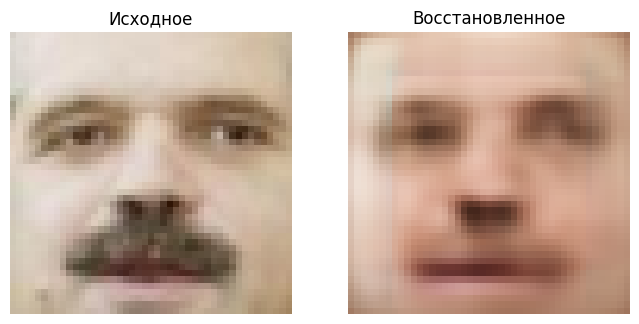

0.0 1.0 0.06810643 0.9299682


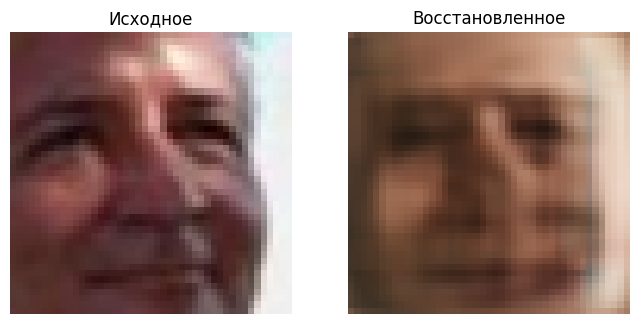

0.101960786 0.7882353 0.16543564 0.7946173


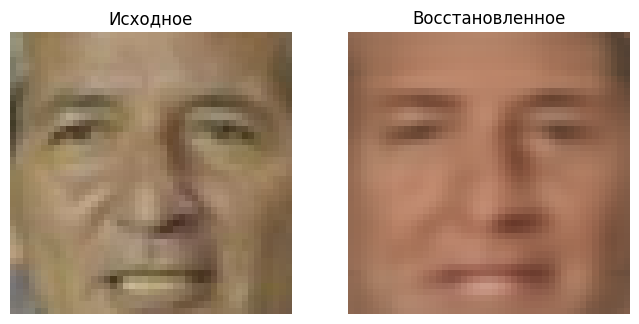

0.0 0.95686275 0.060979873 0.7322868


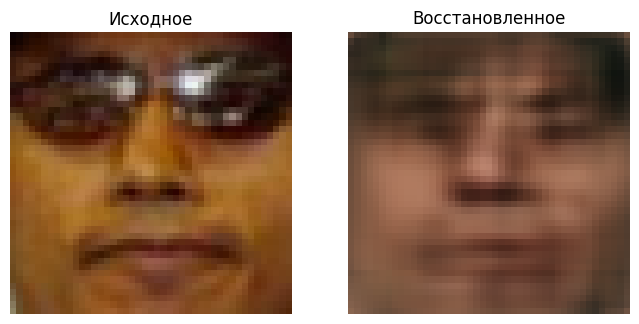

0.06666667 0.9607843 0.09244602 0.8365945


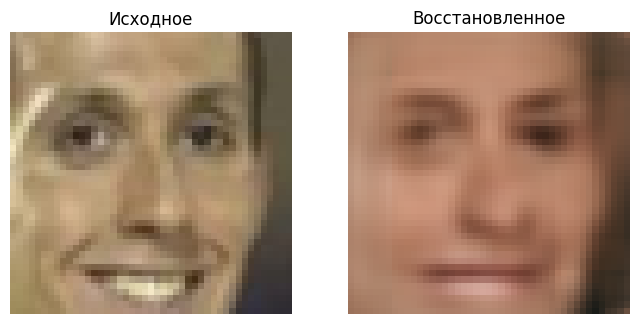

0.07450981 0.83137256 0.05831216 0.86938167


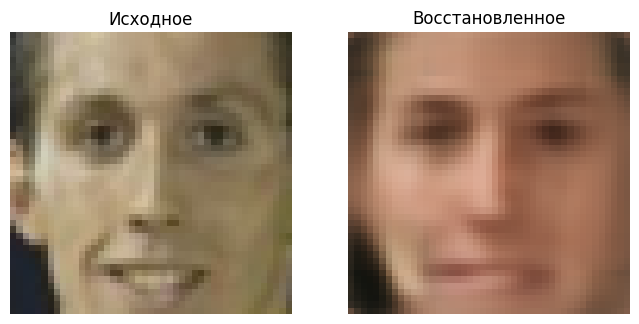

0.0 1.0 0.074942976 0.8699348


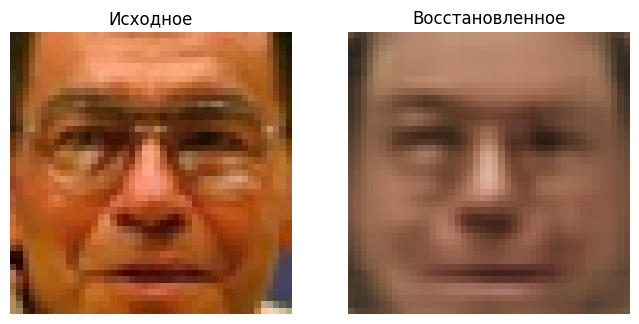

0.0 1.0 0.09131564 0.90047896


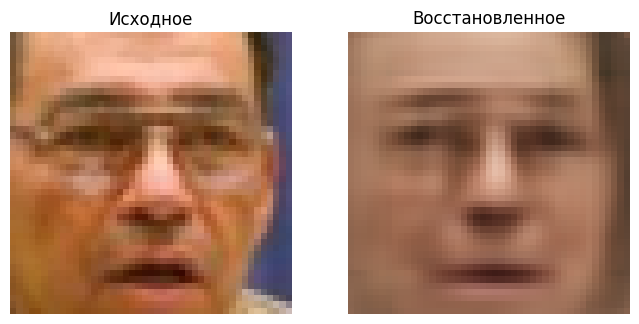

0.003921569 0.9019608 0.08356821 0.8609536


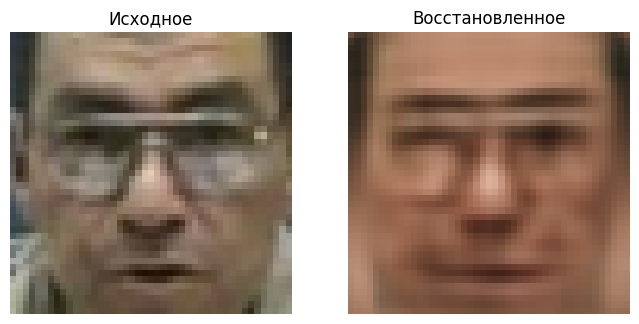

0.03529412 1.0 0.12314632 0.90205276


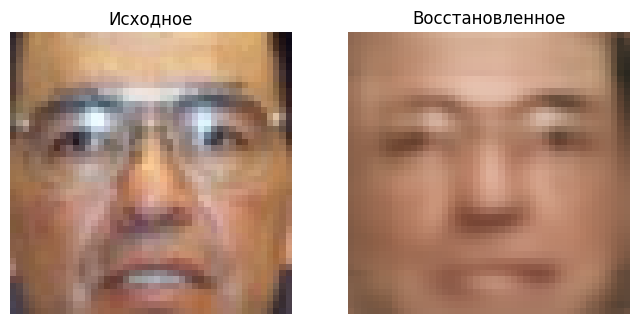

0.043137256 0.99215686 0.1720115 0.9010169


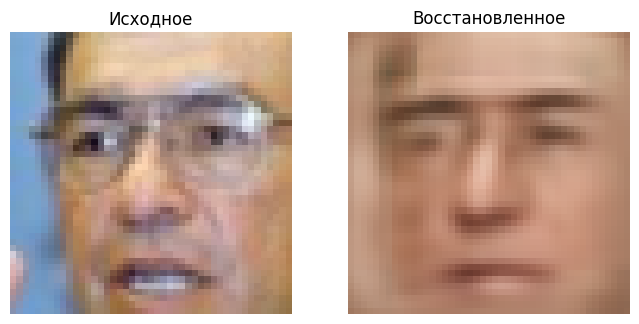

0.0 1.0 0.12241791 0.8504847


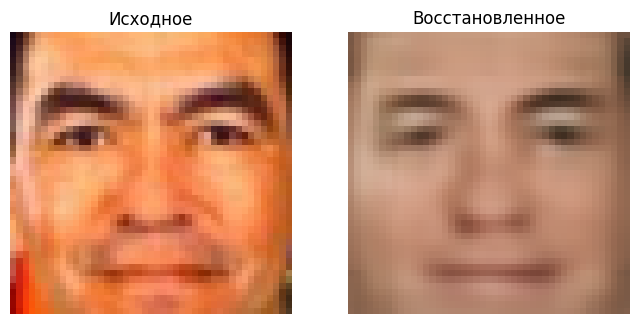

0.003921569 0.92156863 0.059811078 0.8532434


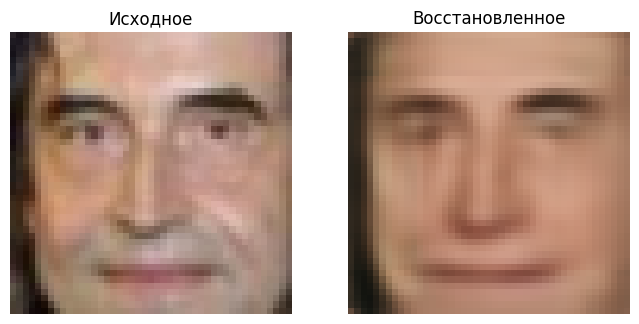

0.03137255 1.0 0.3048801 0.89435965


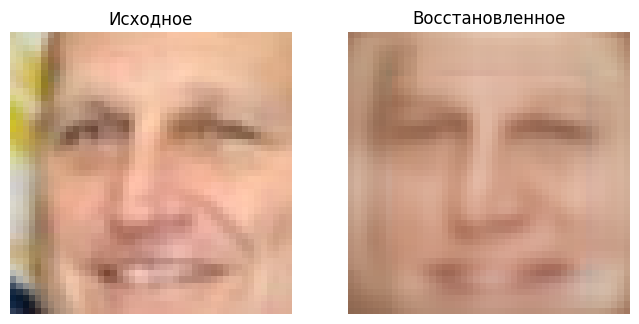

0.0 1.0 0.13019572 0.92691606


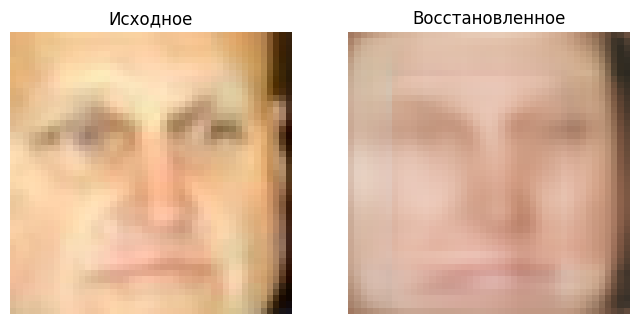

0.023529412 0.972549 0.15974636 0.8366639


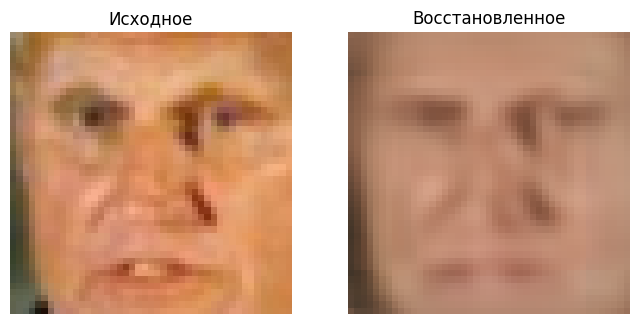

0.015686275 0.9607843 0.108814046 0.85999185


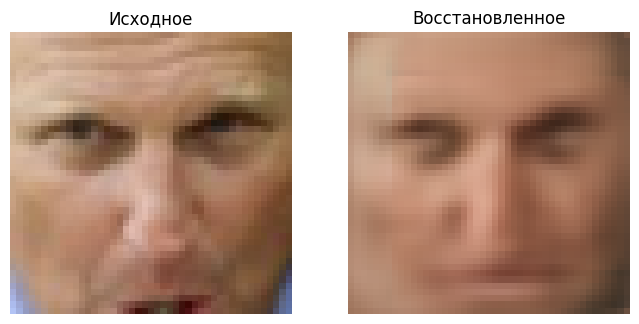

0.3254902 1.0 0.36645263 0.937459


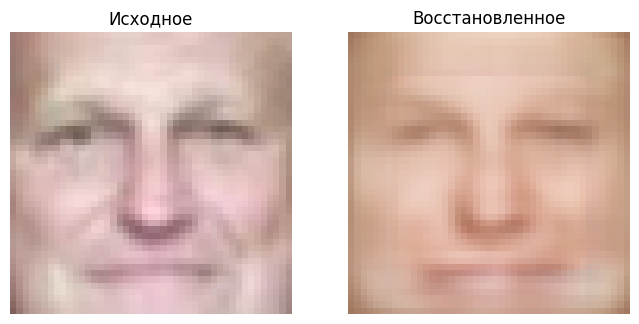

0.09803922 0.8745098 0.17337815 0.8306489


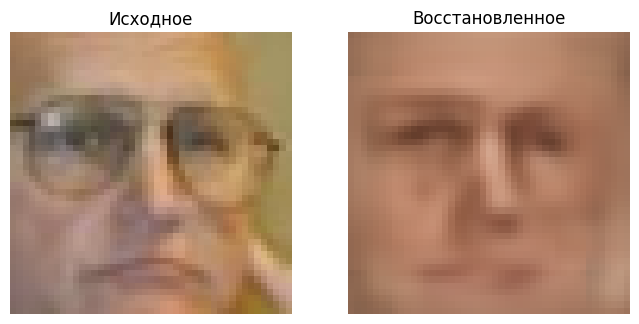

0.039215688 1.0 0.28972462 0.89434725


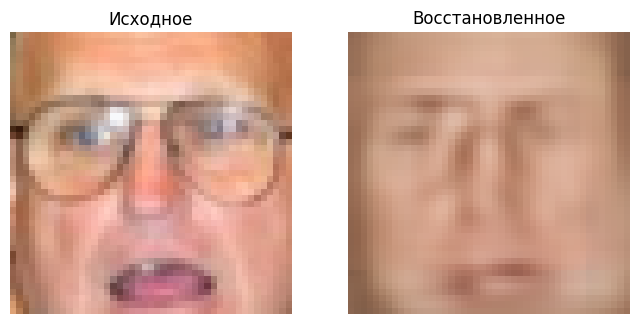

In [ ]:
model.eval()
result = []
for image in val_images[:20]:
    # Показываем настоящее исходное изображение
    val_img_show = image.permute(1, 2, 0).cpu().numpy()
    if val_img_show.max() > 1:
        val_img_show = val_img_show / 255.

    # Подготовка картинки для модели:
    val_img = image.unsqueeze(0).float().to(device)  # (1, 3, 45, 45)

    recon = model(val_img)[0]
    recon_img = recon.detach().cpu().squeeze()
    recon_img = recon_img.permute(1,2,0).numpy()
    if recon_img.max() > 1:
      recon_img = recon_img / 255.
    result.append((val_img_show, recon_img))

for i, pair in enumerate(result):
    print( pair[0].min(), pair[0].max(), pair[1].min(), pair[1].max())
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pair[0])
    plt.axis('off')
    plt.title('Исходное')

    plt.subplot(1, 2, 2)
    plt.imshow(pair[1])
    plt.axis('off')
    plt.title('Восстановленное')
    plt.show()

Что вы можете сказать про результат?

Декодер восстанавливет изображения  с низким качеством.

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
#Гененрируем 25 векторов из норамлного распределения в размерности латентного вектора
channels, height, width = 4, 21, 21
z = np.random.randn(25, channels, height, width)
z_torch = torch.from_numpy(z).float().to(device)

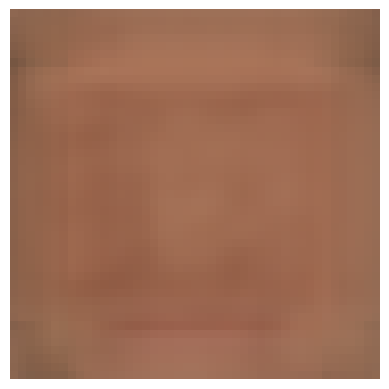

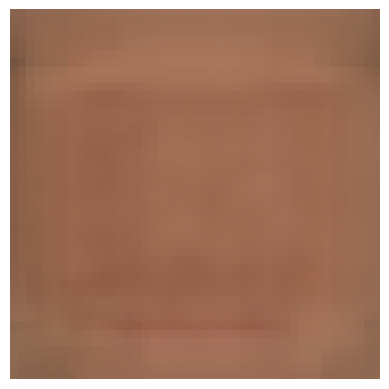

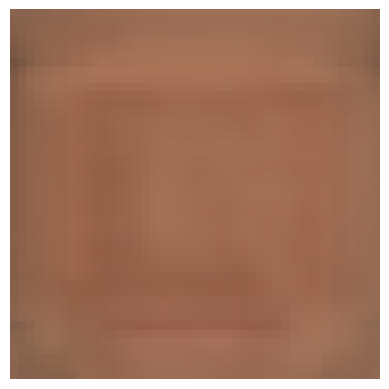

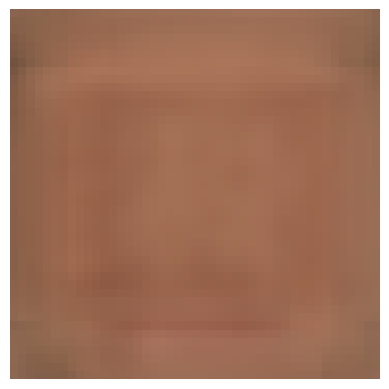

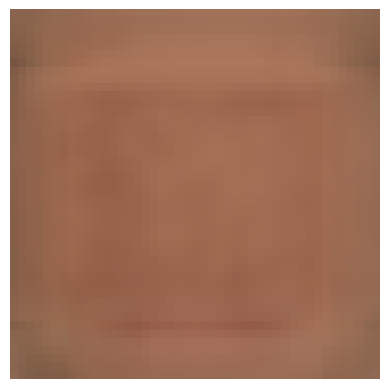

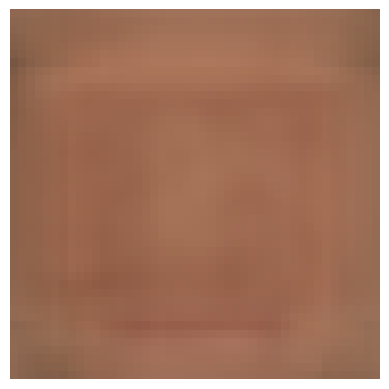

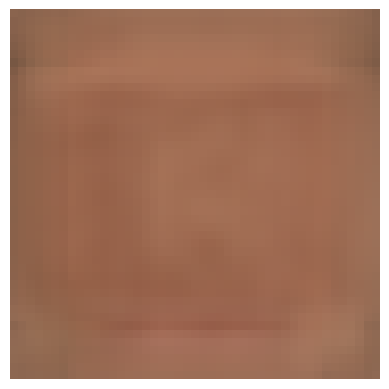

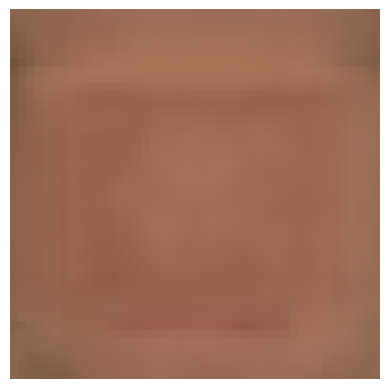

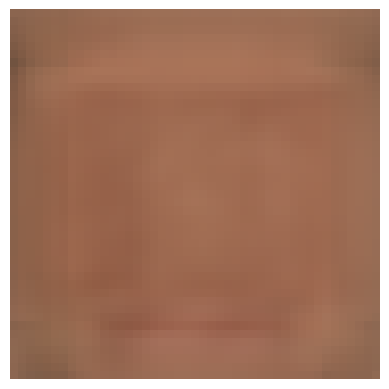

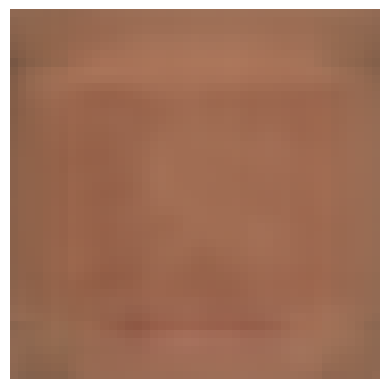

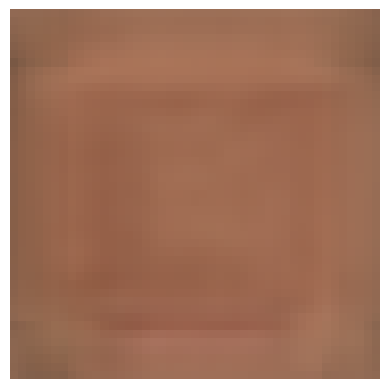

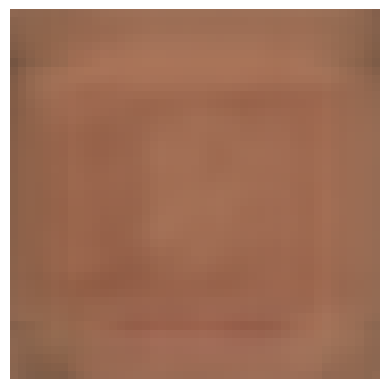

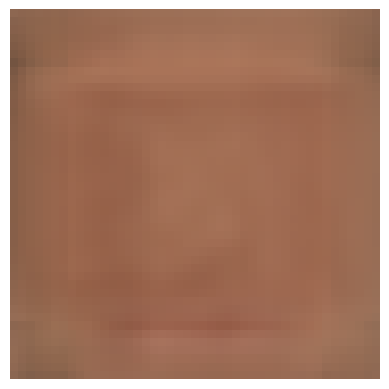

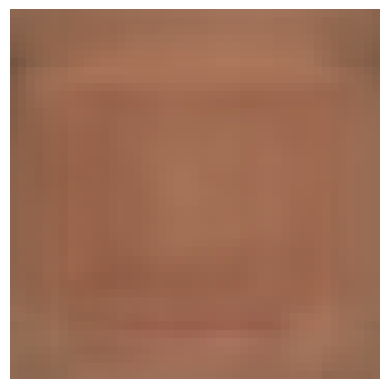

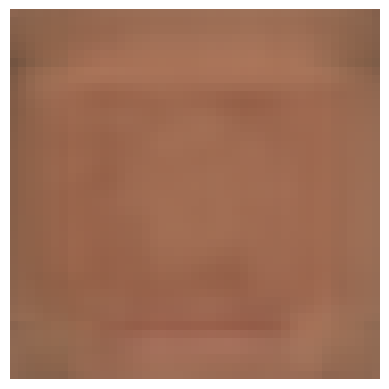

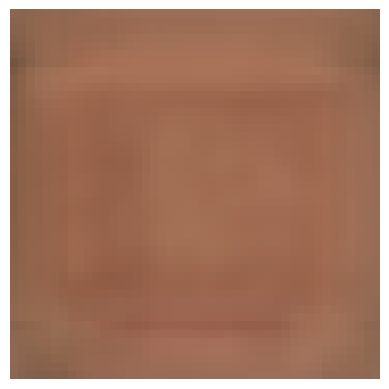

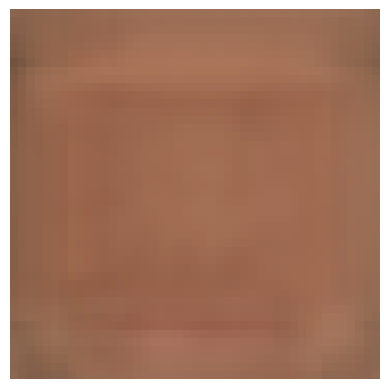

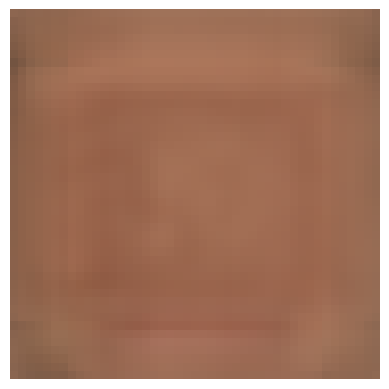

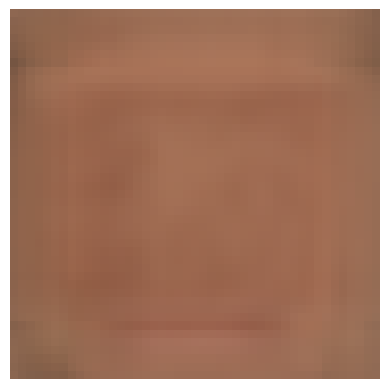

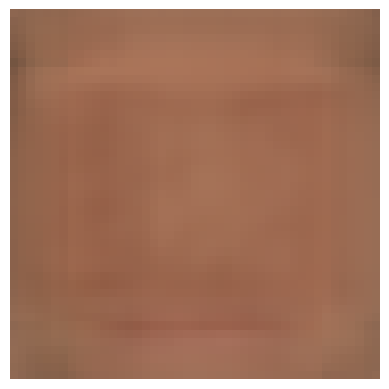

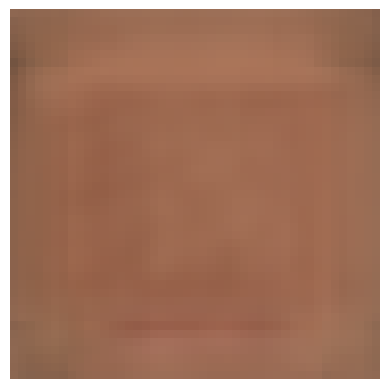

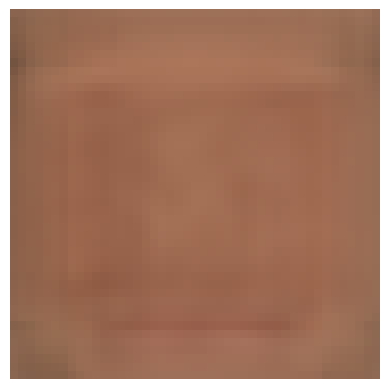

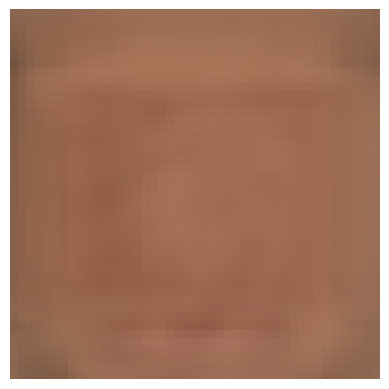

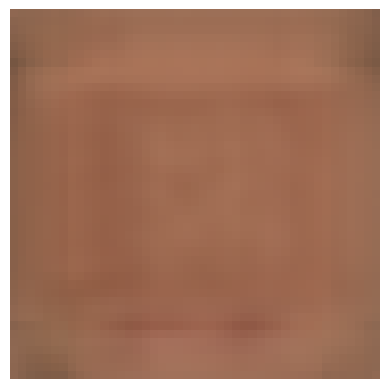

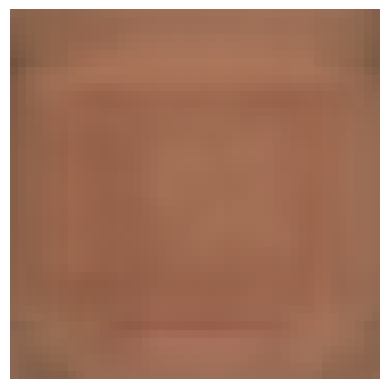

In [ ]:
#подаем сгененрированные вектора на вход декодеру
model.eval()
with torch.no_grad():
    decoded = model.decoder(z_torch)
for i in range(decoded.shape[0]):
    img = decoded[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()



Сгенерированные декодером изображения не похожи на лица

In [ ]:
# прогоним через энкодер 100 изображений и вычислим среднее и среднеквадратическое отклонение по батчу получившихся латентных векторов
all_latents = []
model.eval()
for val_img in val_images[:100]:
    val_img = val_img.unsqueeze(0)       # (45, 45, 3) -> (1, 45, 45, 3)
    val_img = val_img.float()
    val_img = val_img.to(device)
    latent = model.encoder(val_img)
    all_latents.append(latent)

In [ ]:
all_latents = torch.cat(all_latents, dim=0)

In [ ]:
all_latents.shape

torch.Size([100, 4, 21, 21])

In [ ]:
print("Latent shape from encoder:", latent.shape)
print("z_torch shape:", z_torch.shape)

Latent shape from encoder: torch.Size([1, 4, 21, 21])
z_torch shape: torch.Size([25, 4, 21, 21])


In [ ]:
mean = all_latents.mean(dim=0)
std = all_latents.std(dim=0)
print(mean.shape, std.shape)

torch.Size([4, 21, 21]) torch.Size([4, 21, 21])


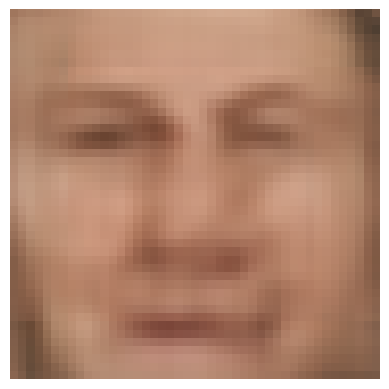

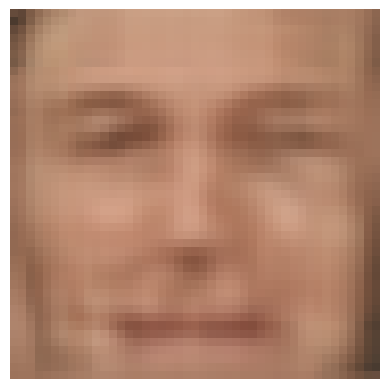

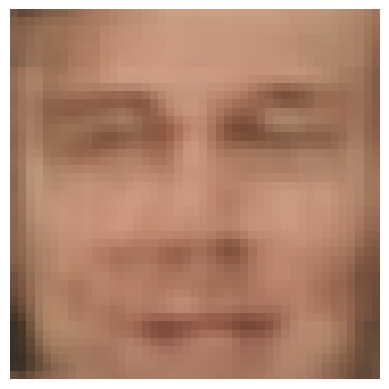

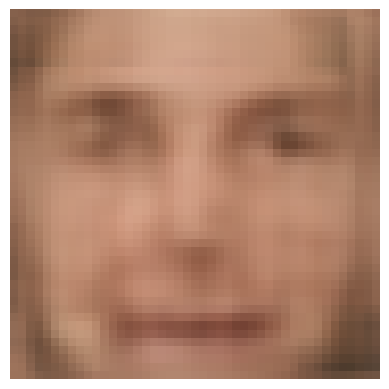

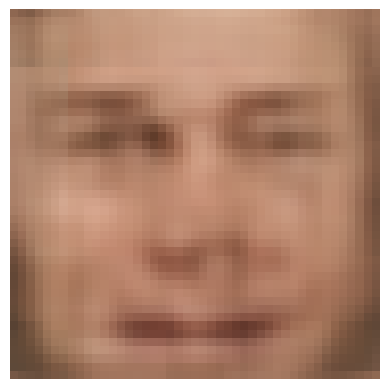

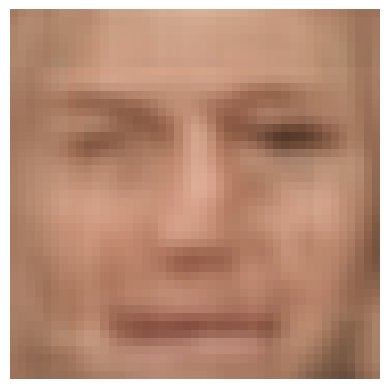

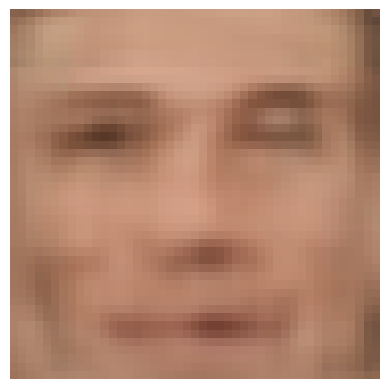

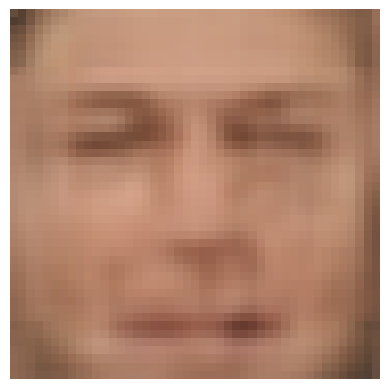

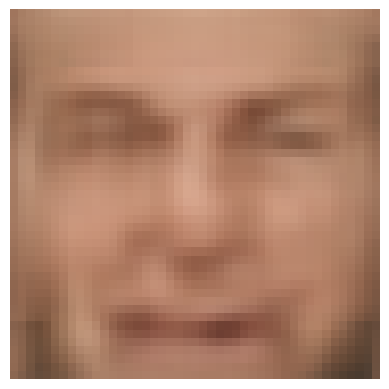

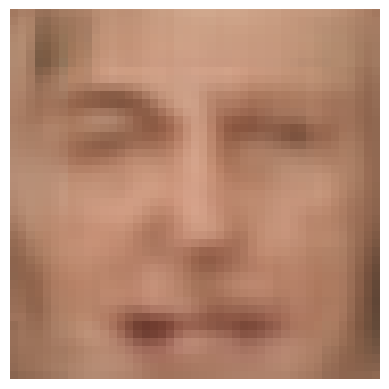

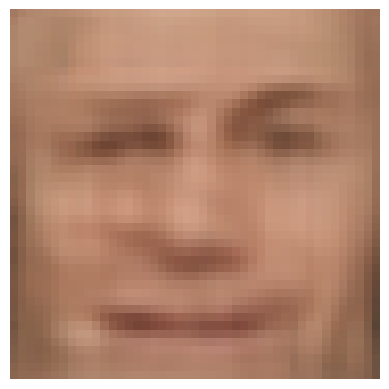

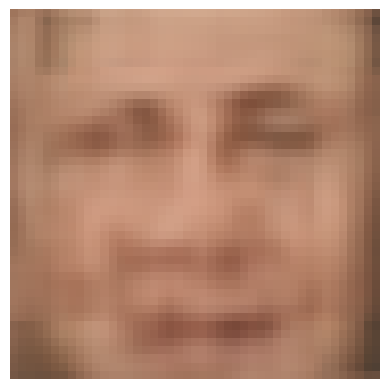

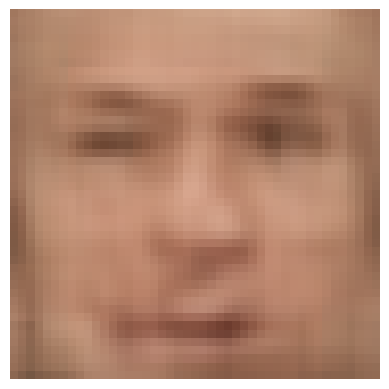

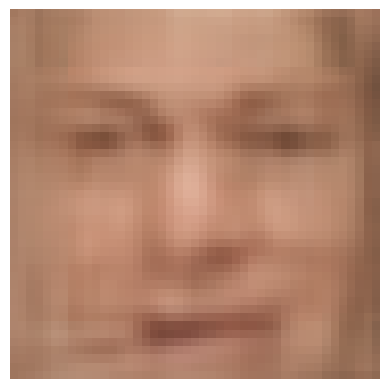

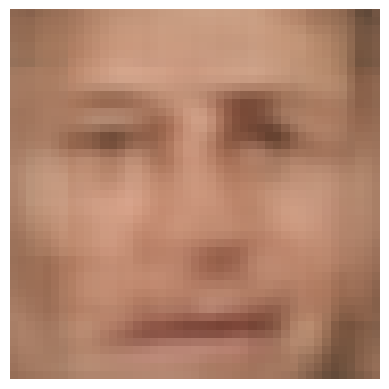

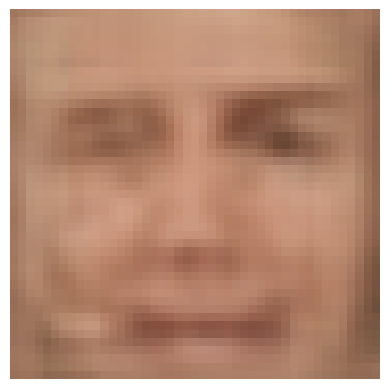

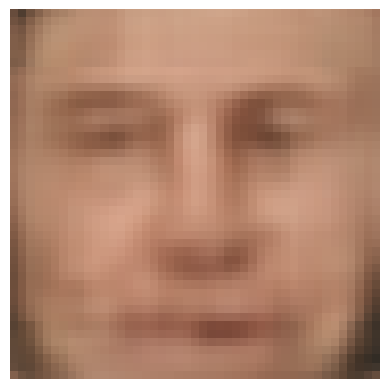

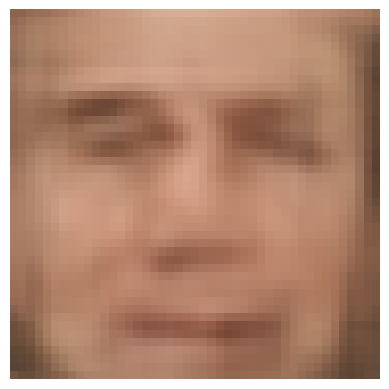

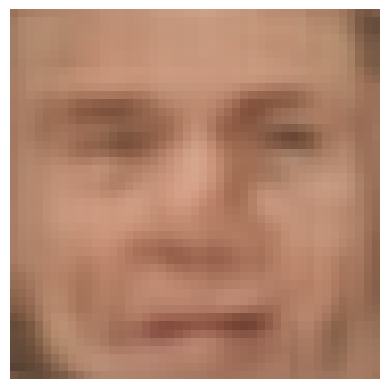

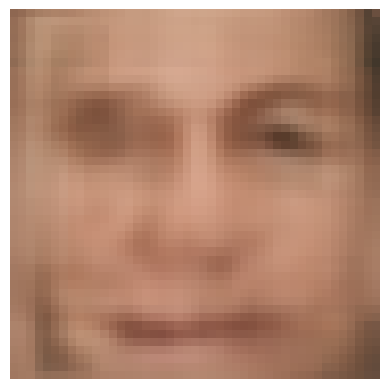

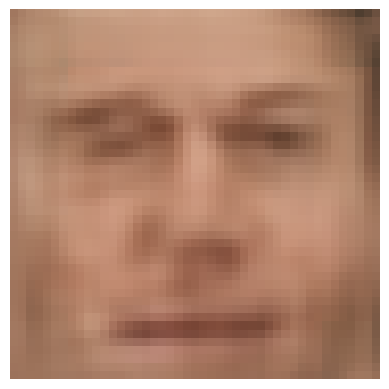

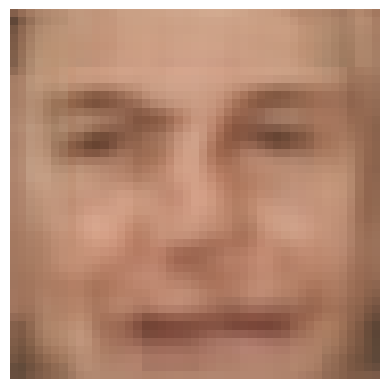

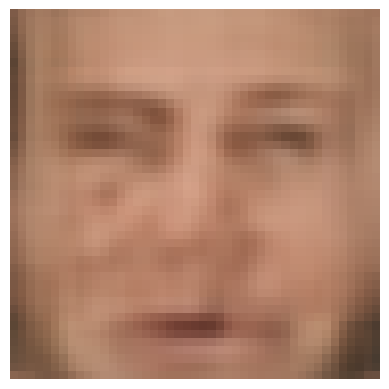

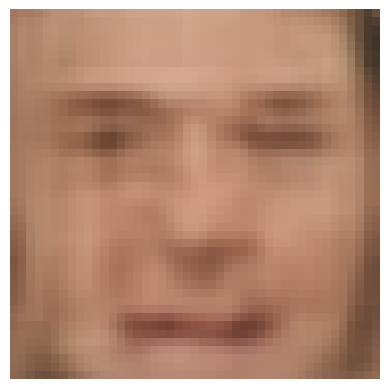

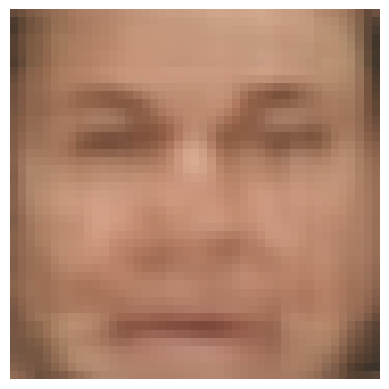

In [ ]:
#Скорректируем случайные вектора с учетом вычесленных статистик
z_adjusted = z_torch * std + mean

model.eval()
with torch.no_grad():
    decoded = model.decoder(z_adjusted)
for i in range(decoded.shape[0]):
    img = decoded[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Сгенерированные изображения стали похожи на лица

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
train_attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
# из выборки изображений найдем несколько (~15) людей с улыбками и столько же без.
#train_images,
smiles_idx = train_attrs['Smiling'].sort_values(ascending=False)[:15].index
smiles_idx

Index([8643, 1816, 5624, 1045, 4681, 6139, 1359, 2031, 1955, 9004,  459, 6166,
        682,  983, 9165],
      dtype='int64')

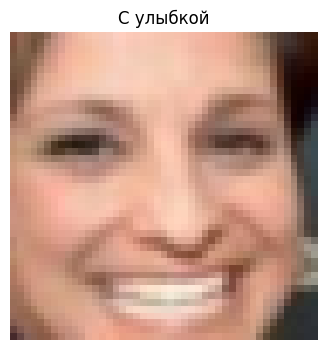

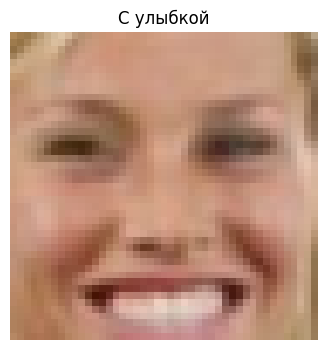

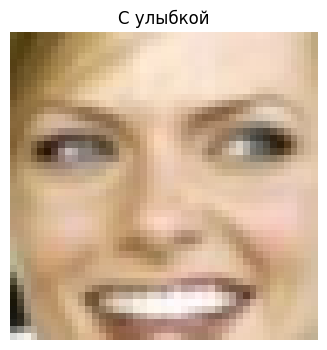

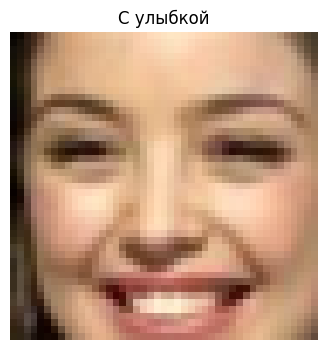

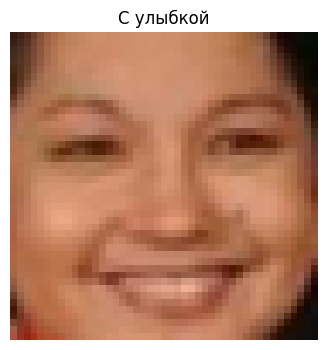

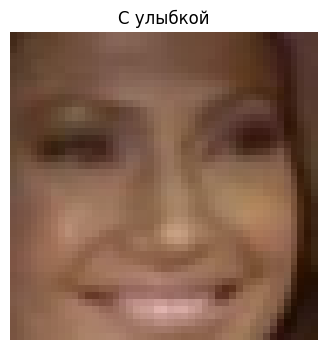

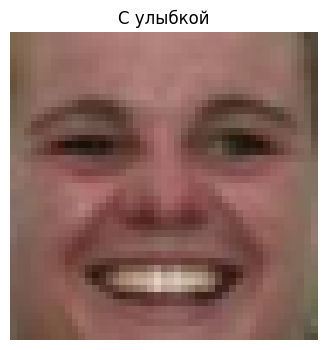

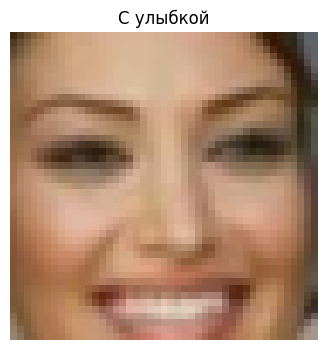

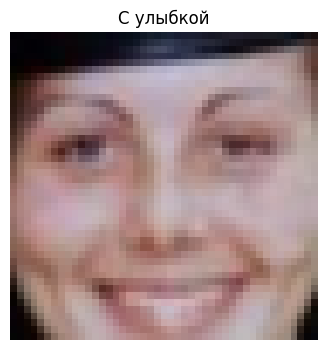

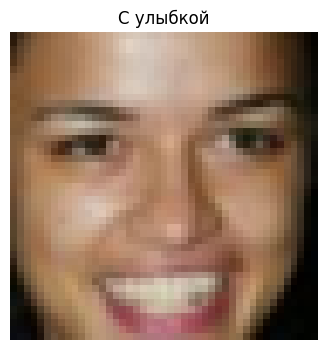

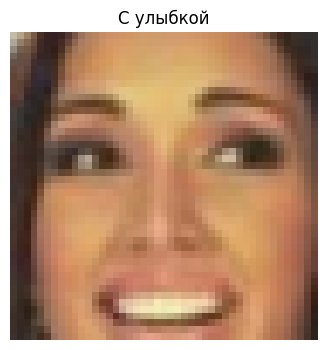

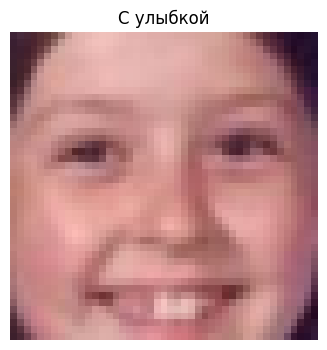

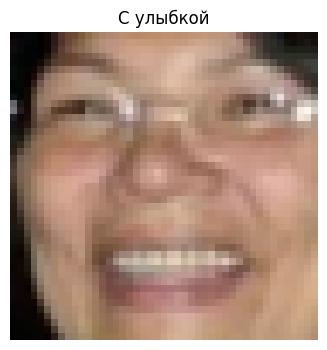

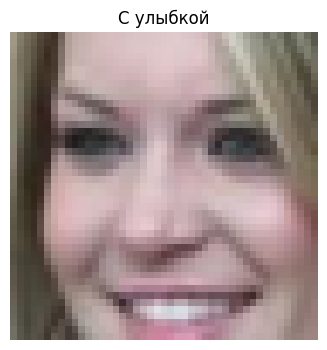

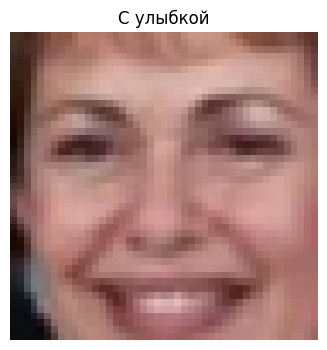

In [ ]:
smiles = []
for image in train_images[smiles_idx]:
    # Показываем настоящее исходное изображение
    image = image.permute(1,2,0)
    smiles.append(image)

for image in smiles:
    plt.figure(figsize=(8, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title('С улыбкой')

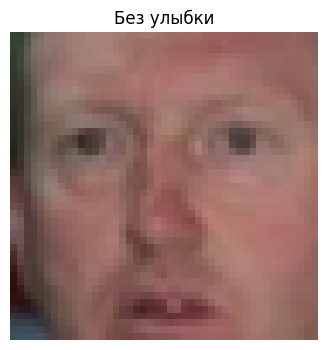

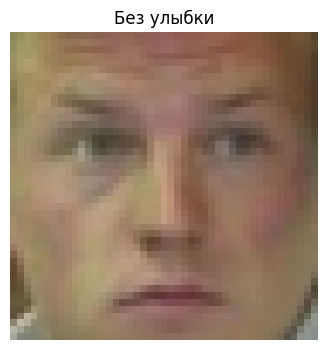

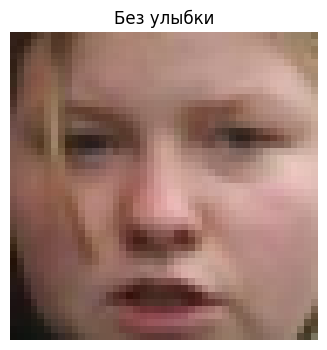

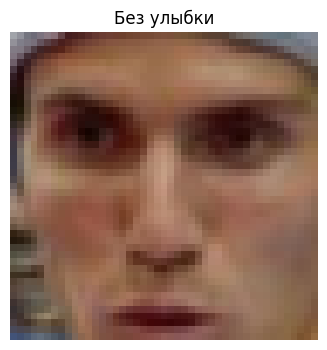

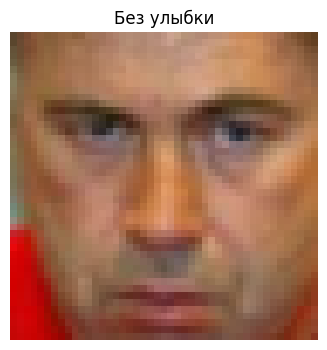

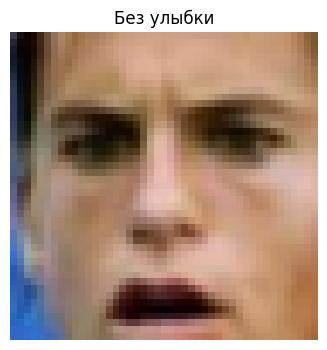

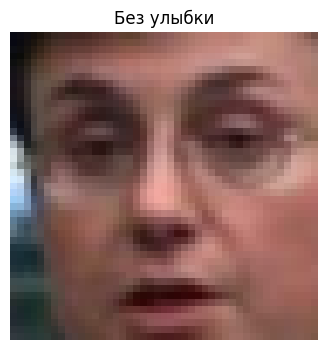

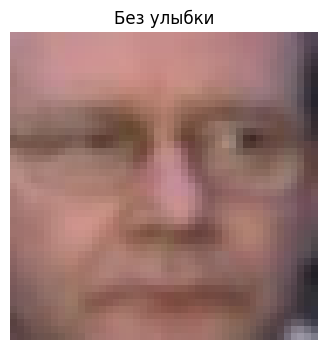

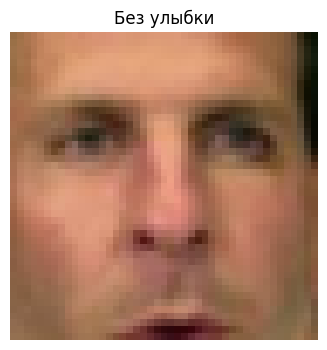

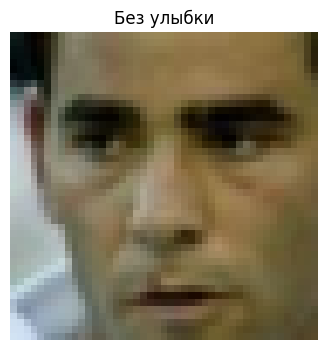

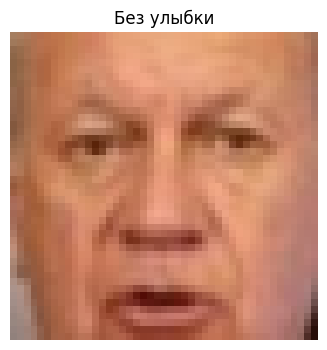

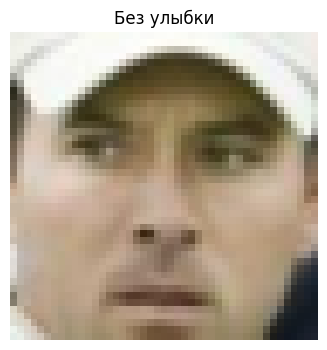

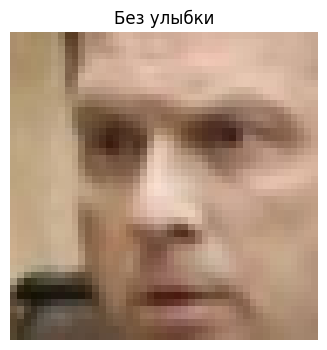

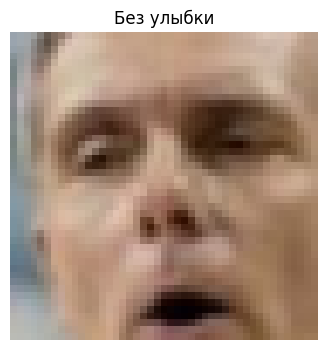

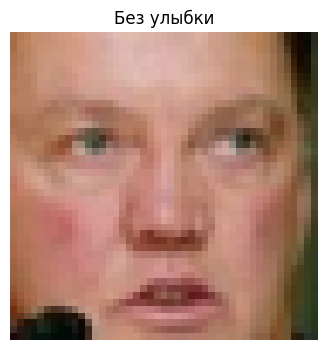

In [ ]:
no_smiles_idx = train_attrs['Smiling'].sort_values(ascending=True)[:15].index
no_smiles_idx
no_smiles = []
for image in train_images[no_smiles_idx]:
    # Показываем настоящее исходное изображение
    image = image.permute(1,2,0)
    no_smiles.append(image)

for image in no_smiles:
    plt.figure(figsize=(8, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Без улыбки')

In [ ]:
#Вычислим латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.
smiles_latent = []
model.eval()
for img in  train_images[smiles_idx]:
    img = img.unsqueeze(0)       # (45, 45, 3) -> (1, 45, 45, 3)
    img = img.float()
    img = img.to(device)
    latent = model.get_latent_vector(img)
    smiles_latent.append(latent)


no_smiles_latent = []
model.eval()
for img in  train_images[no_smiles_idx]:
    img = img.unsqueeze(0)       # (45, 45, 3) -> (1, 45, 45, 3)
    img = img.float()
    img = img.to(device)
    latent = model.get_latent_vector(img)
    no_smiles_latent.append(latent)

smiles_latent = torch.cat(smiles_latent, dim=0)
no_smiles_latent = torch.cat(no_smiles_latent, dim=0)

print(smiles_latent.shape, no_smiles_latent.shape )

torch.Size([15, 4, 21, 21]) torch.Size([15, 4, 21, 21])


In [ ]:
#Вычислим, собственно, вектор улыбки -- посчитаем разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.#
mean_smiles = smiles_latent.mean(dim=0)
mean_no_smiles = no_smiles_latent.mean(dim=0)
print(mean_smiles.shape, mean_no_smiles.shape )

torch.Size([4, 21, 21]) torch.Size([4, 21, 21])


In [ ]:
smiles_diff =   mean_smiles - mean_no_smiles
smiles_diff.shape

torch.Size([4, 21, 21])

In [ ]:
#А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького

In [ ]:
added_smile = []
model.eval()
for latent in  no_smiles_latent:
    add_smile =  latent + smiles_diff
    add_smile = torch.tensor(add_smile)
    added_smile.append(add_smile)

modified_latents = torch.stack(added_smile)

<ipython-input-105-813a7c303e40>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  add_smile = torch.tensor(add_smile)


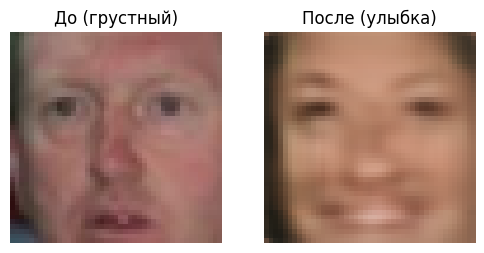

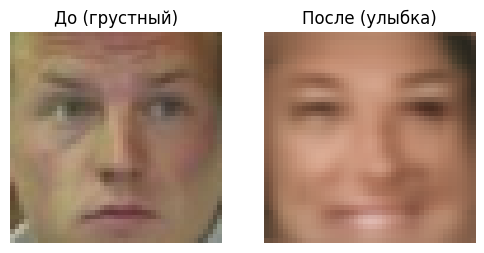

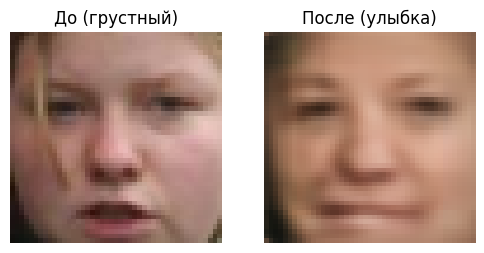

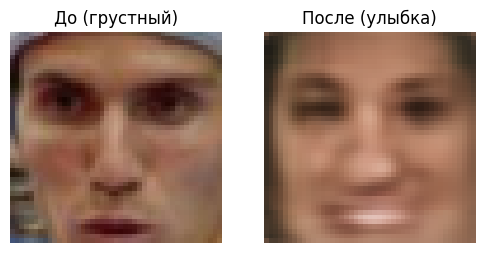

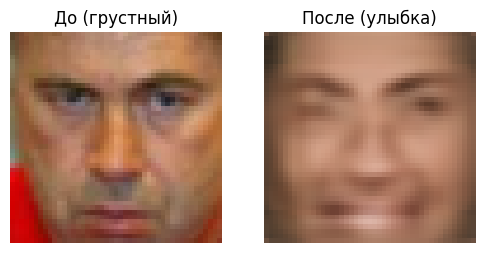

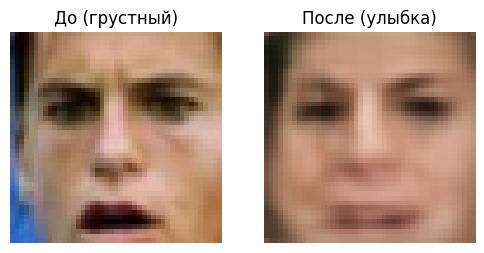

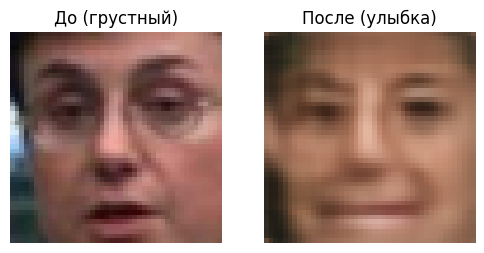

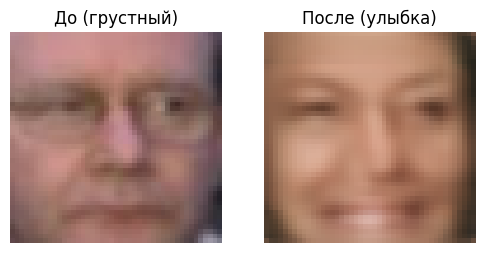

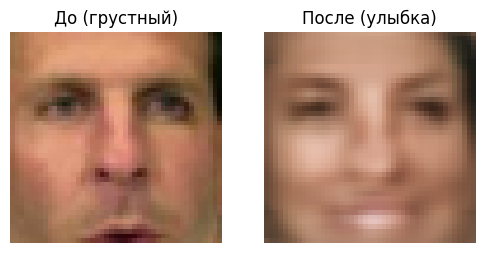

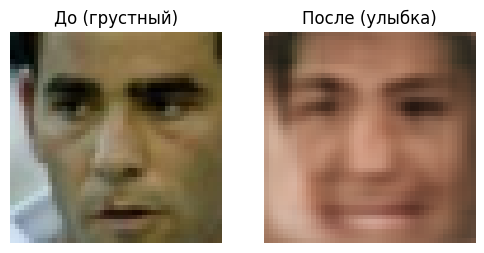

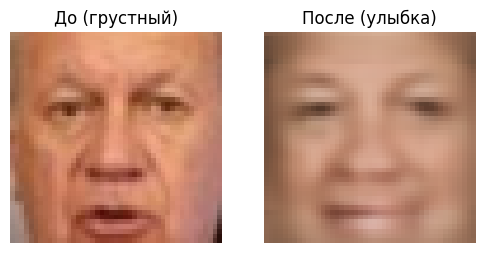

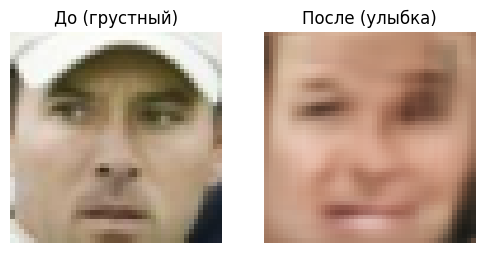

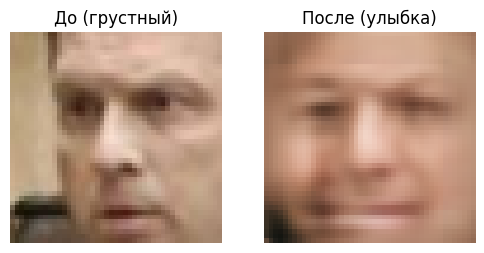

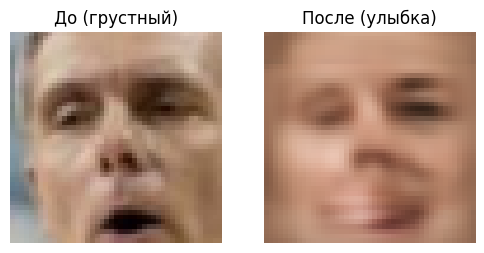

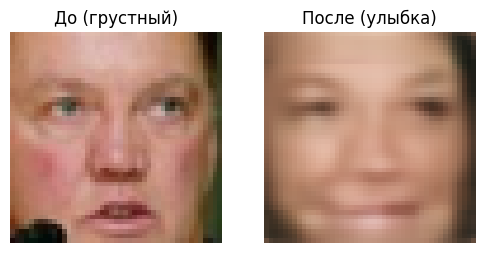

In [ ]:
with torch.no_grad():
    smile_decoded = model.decoder(modified_latents)

# Показываем: оригинал (без улыбки) → версия с добавленной улыбкой
for i in range(len(no_smiles_idx)):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Оригинальное изображение (до улыбки)
    img_orig = train_images[no_smiles_idx[i]].cpu().permute(1, 2, 0).numpy()
    axs[0].imshow(img_orig)
    axs[0].set_title("До (грустный)")
    axs[0].axis('off')

    # Изображение после добавления улыбки
    img_smiled = smile_decoded[i].cpu().permute(1, 2, 0).numpy()
    axs[1].imshow(img_smiled)
    axs[1].set_title("После (улыбка)")
    axs[1].axis('off')

    plt.show()


Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import datasets, transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)



# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_mnist = next(iter(train_loader))


In [ ]:
data_mnist[1]

tensor([9, 1, 8, 8, 5, 5, 8, 5, 2, 5, 6, 9, 7, 9, 4, 4, 0, 4, 8, 4, 6, 5, 5, 6,
        2, 7, 7, 9, 3, 0, 2, 7])

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super(VAE, self).__init__()

        # Размерность латентного пространства
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), #28 -> 26
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16,  kernel_size=3), #26-> 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8,  kernel_size=3), #24 -> 22
           )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            out = self.encoder(dummy)
            self.flat_dim = out.view(1, -1).shape[1]
            self.encoder_output_shape = out.shape[1:]

        self.flatten = nn.Flatten()  # [B, 8, 22, 22] → [B, 3872]
        self.fc_mu = nn.Linear(self.flat_dim, self.latent_dim)
        self.fc_logsigma = nn.Linear(self.flat_dim, self.latent_dim)
        self.fc_decode = nn.Linear(self.latent_dim, self.flat_dim)


        # Декодер



        self.decoder = nn.Sequential(
            nn.Unflatten(1, self.encoder_output_shape),      # [B, 8, 22, 22]
            nn.ConvTranspose2d(8, 16, kernel_size=3),         # 22 → 24
            nn.ReLU(),
            nn.Dropout(0.5),
            #nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 32, kernel_size=3),        # 24 → 26
            nn.ReLU(),
            nn.Dropout(0.5),
            #nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3),         # 26 → 28
            nn.Sigmoid()
        )

    def encode(self, x):
        '''<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>'''
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma



    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>

            # Сохраняем форму тензоров
            #batch_size, channels, height, width = mu.shape

            # Reshape для удобства операций
            #mu_flat = mu.view(batch_size, -1)
            #logsigma_flat = logsigma.view(batch_size, -1)

            # Семплирование
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)

            # Возвращаем к исходной форме
            #sample = sample_flat.view(batch_size, channels, height, width)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu





    def decode(self, z):
        '''<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>'''

        # decoding
        x = self.fc_decode(z)
        #print("fc_decode out:", torch.isnan(x).any().item(), x.min().item(), x.max().item())
        reconstruction = self.decoder(x)
        return reconstruction





    def forward(self, x):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        # encoding
        mu, logsigma = self.encode(x)

        #sampling
        z = self.gaussian_sampler(mu, logsigma)

        # decoding

        reconstruction =  self.decode(z)

        return reconstruction, mu, logsigma




Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - torch.exp(logsigma))
    return loss




def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    eps = 1e-8  # защита от log(0)
    reconstruction = torch.clamp(reconstruction, eps, 1 - eps)

    loss = -torch.sum(
        x * torch.log(reconstruction) + (1 - x) * torch.log(1 - reconstruction)
    )
    return loss


def loss_vae(x, mu, logsigma, reconstruction):

    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)



И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE()
autoencoder = autoencoder.to(device)


optimizer = optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)# <Ваш любимый оптимизатор>

In [ ]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        x = batch[0].to(device).float()
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(x)
        #print("train x min/max:", x.min().item(), x.max().item())
        #print("train reconstruction min/max:", reconstruction.min().item(), reconstruction.max().item())
        loss = criterion(x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          x = batch[0].to(device).float()
          reconstruction, mu, logsigma = autoencoder(x)
          #print("val x min/max:", x.min().item(), x.max().item())
          #print("val reconstruction min/max:", reconstruction.min().item(), reconstruction.max().item())
          loss = criterion(x, mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-115-f967d0521226>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

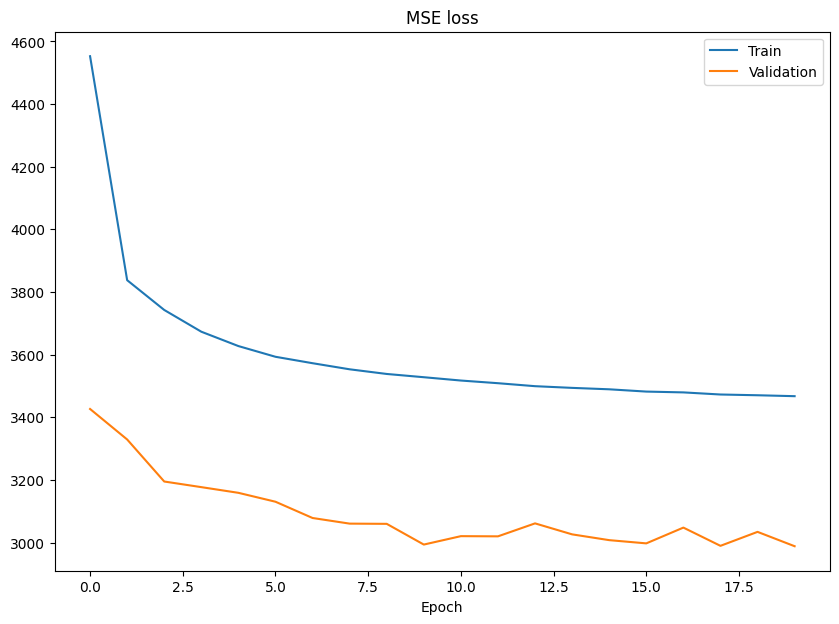

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')


plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

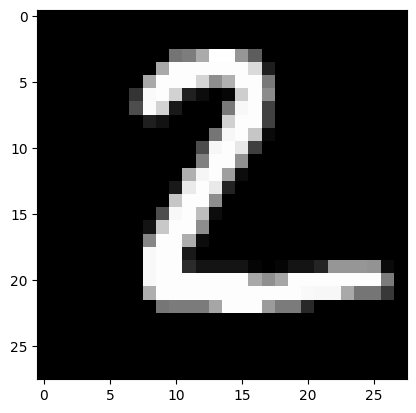

In [ ]:
plt.imshow(test_dataset[1][0].squeeze(), cmap='gray')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)
first_batch = next(iter(val_loader))


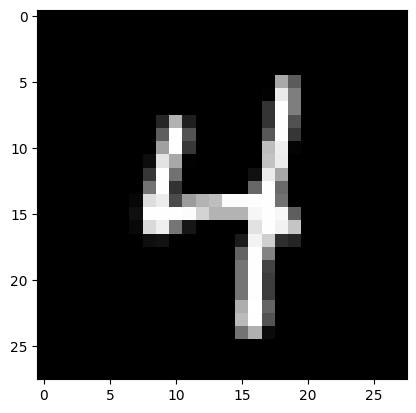

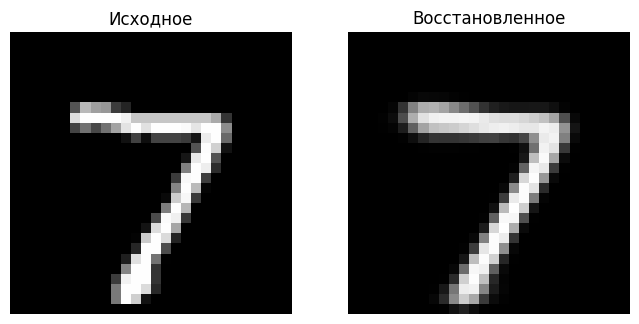

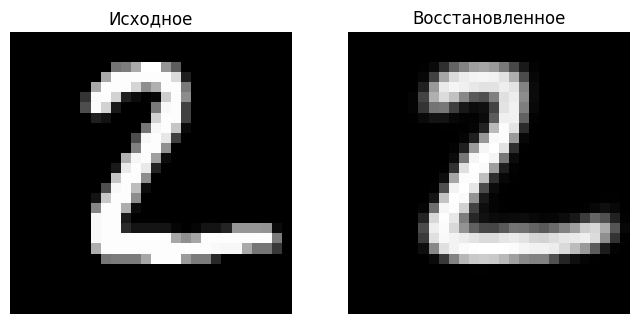

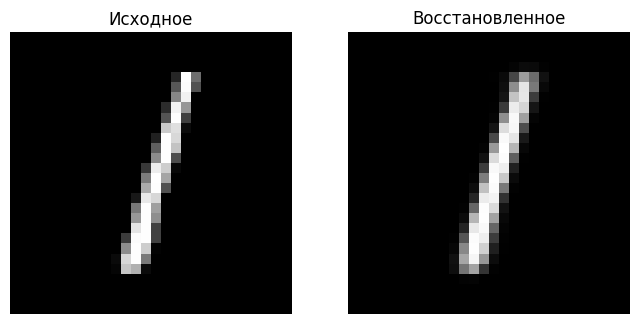

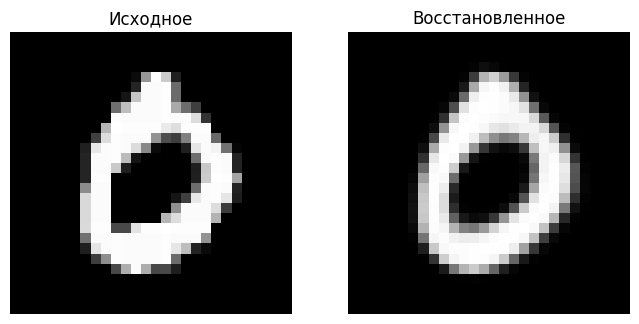

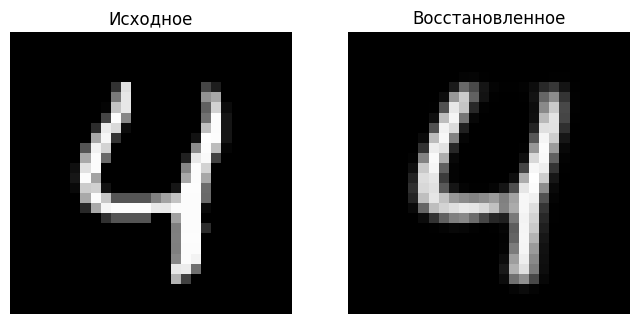

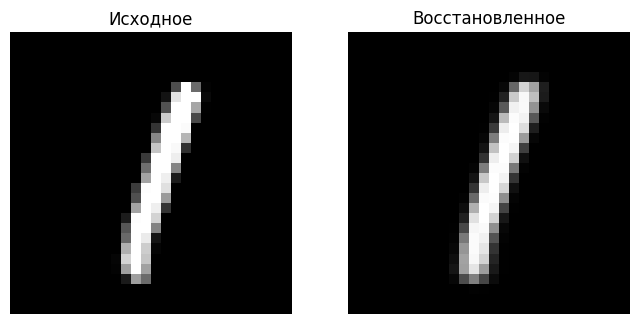

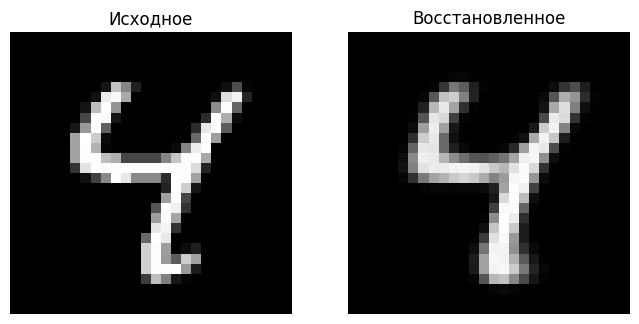

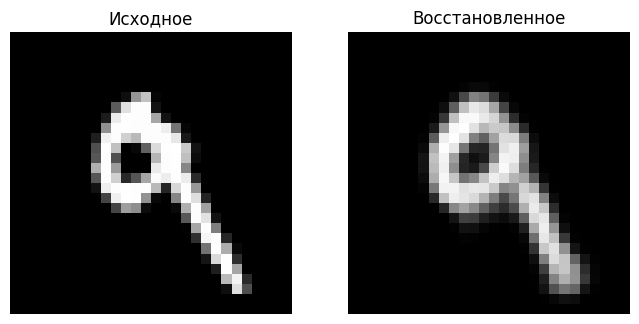

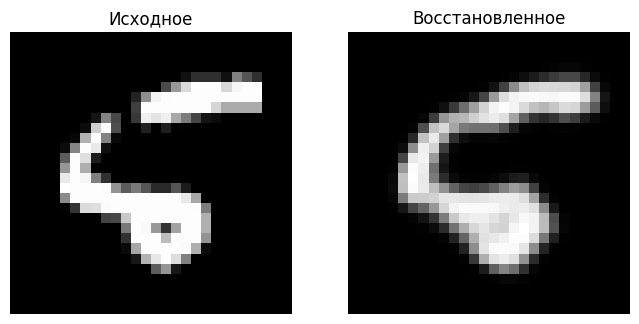

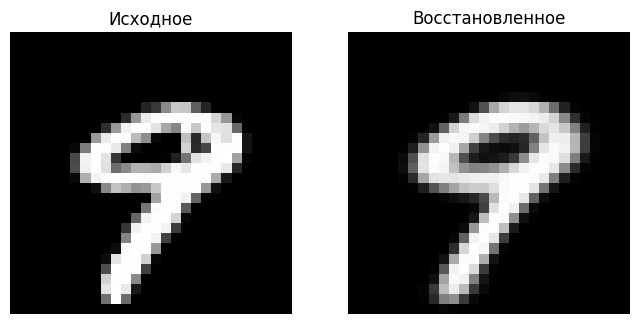

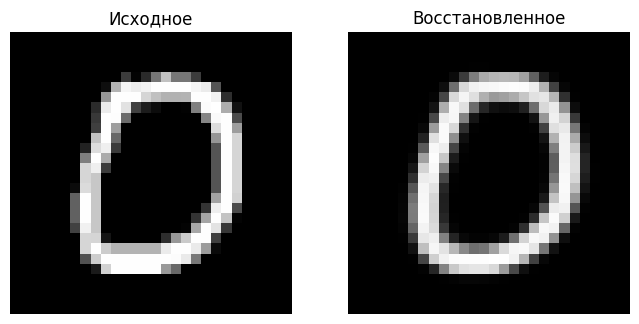

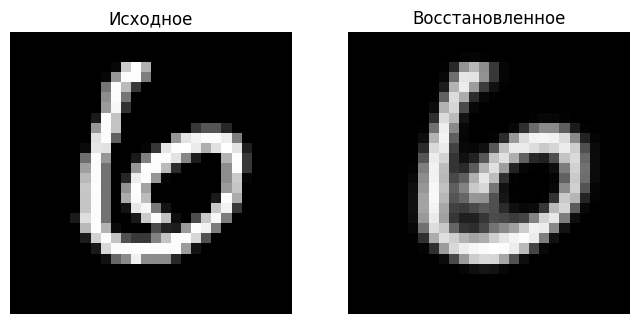

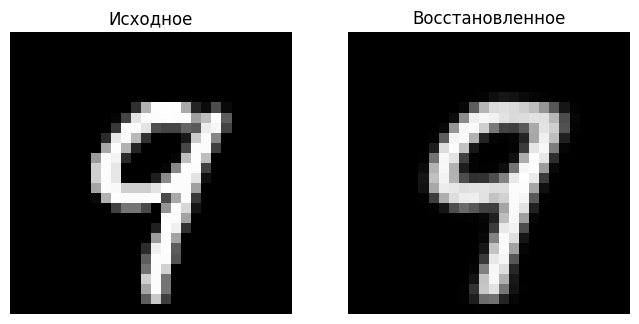

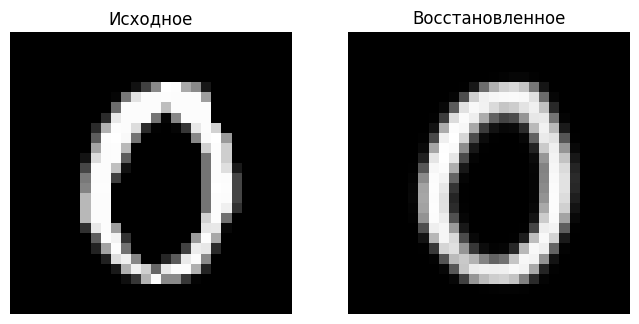

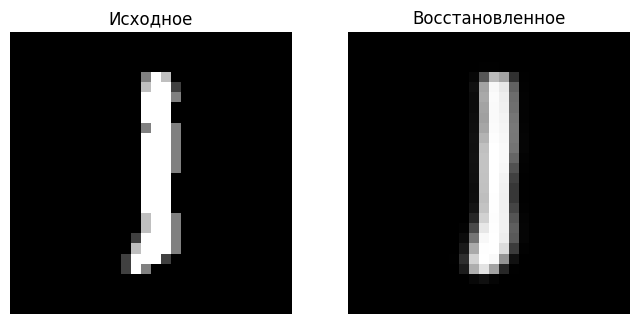

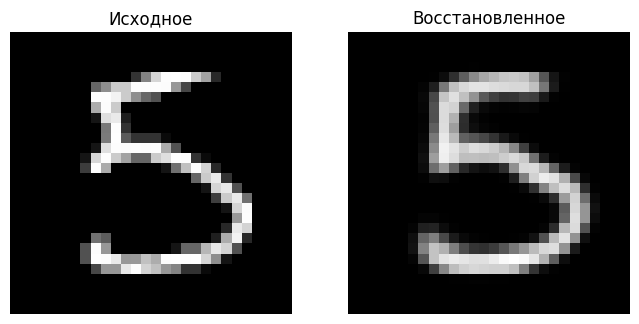

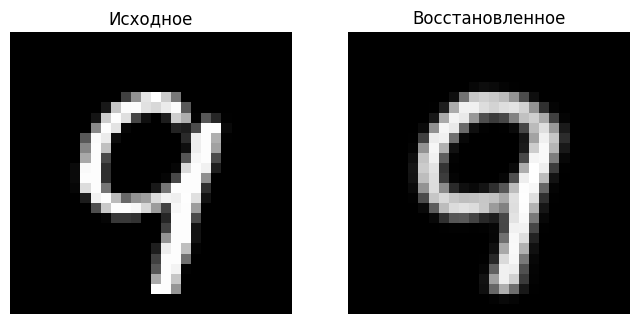

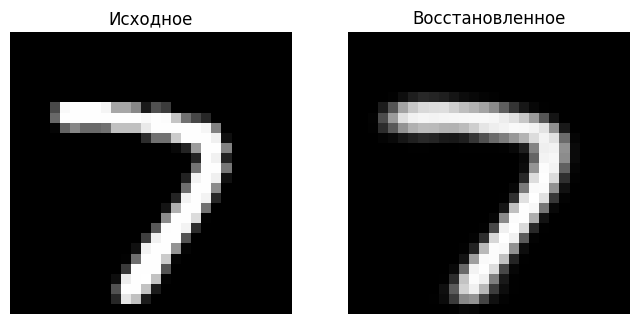

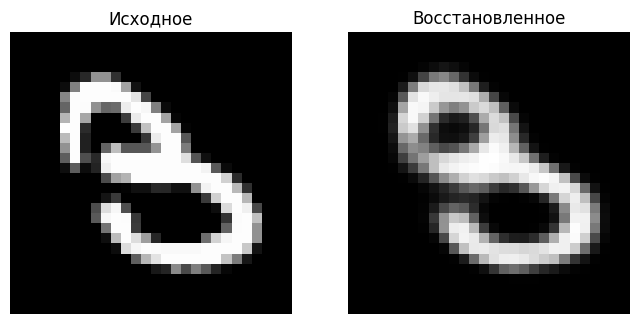

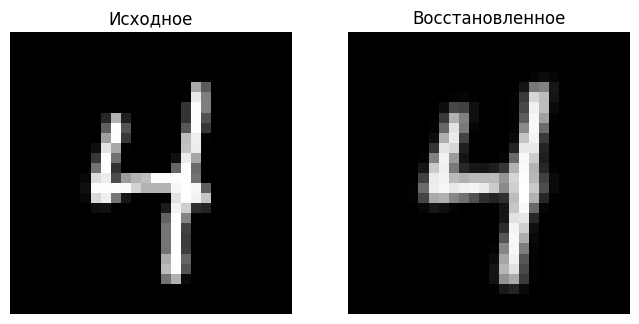

In [ ]:
autoencoder.eval()
result = []
for image in first_batch[0]:
    # Показываем настоящее исходное изображение
    val_img_show = image.squeeze()
    plt.imshow(val_img_show, cmap='gray')

    # Подготовка картинки для модели:
    val_img_show = image.unsqueeze(0).to(device)  # → [1, 1, 28, 28]


    recon = autoencoder(val_img_show)[0]

    recon_img = recon.detach().cpu().squeeze()

    if recon_img.max() > 1:
      recon_img = recon_img / 255.
    result.append((val_img_show, recon_img))

for i, pair in enumerate(result):
    original = pair[0].detach().cpu().squeeze()
    reconstructed = pair[1].detach().cpu().squeeze()

    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.axis('off')
    plt.title('Исходное')

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')
    plt.title('Восстановленное')

    plt.show()


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
#z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
z = np.random.randn(10, autoencoder.latent_dim)
z_torch = torch.from_numpy(z).float().to(device)
z_torch.shape




torch.Size([10, 32])

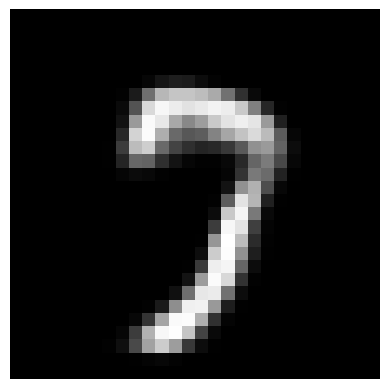

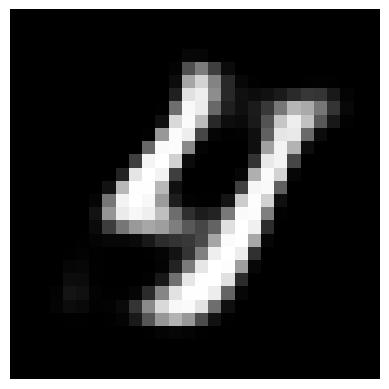

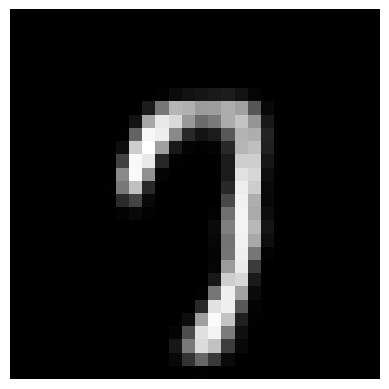

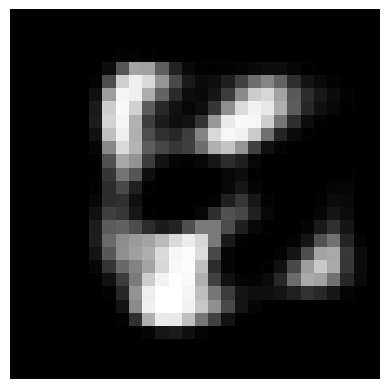

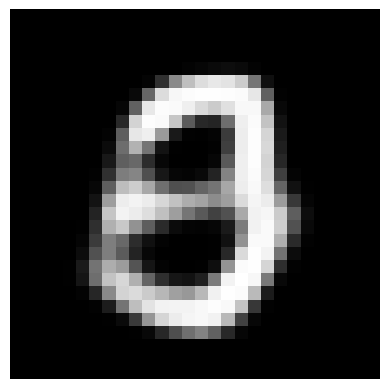

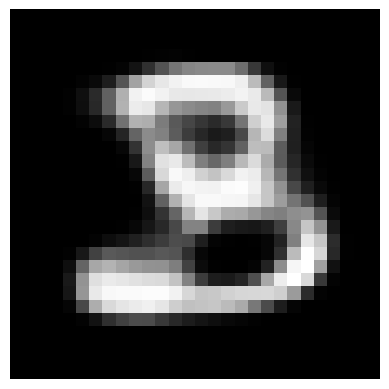

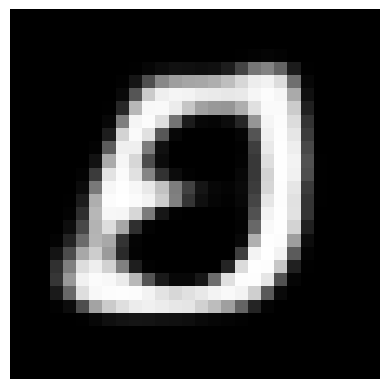

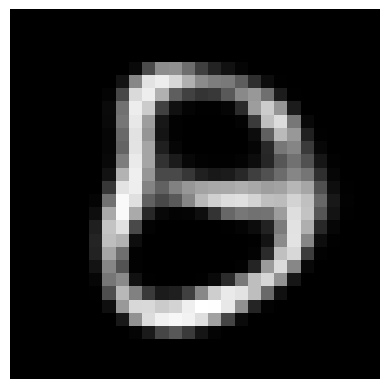

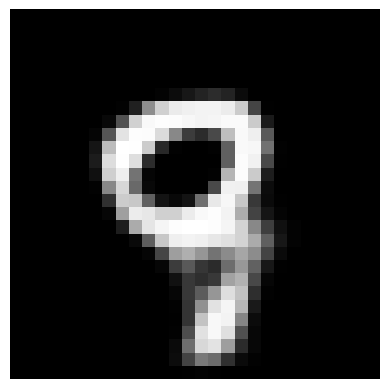

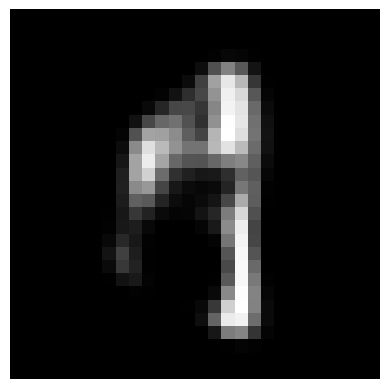

In [ ]:
#подаем сгененрированные вектора на вход декодеру
autoencoder.eval()
with torch.no_grad():
    decoded = autoencoder.decode(z_torch)
for i in range(decoded.shape[0]):
    img = decoded[i].cpu().permute(1, 2, 0).numpy()
    img /= 255.
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


Сгенерированные ихображения не похожи на цифры из-за различия в распредедении случайного вектора и вектора, прошедшего через энкодер. Скорректируем распределение случайного вектора

In [ ]:
# прогоним через энкодер 20 изображений и вычислим среднее и среднеквадратическое отклонение по батчу получившихся латентных векторов
all_latents = []
autoencoder.eval()
for val_img in first_batch[0]:
    val_img = val_img.unsqueeze(0) # (1, 28, 28) -> (1, 1, 28, 28)
    val_img = val_img.float()
    val_img = val_img.to(device)
    mu, logsigma = autoencoder.encode(val_img)
    latent = autoencoder.gaussian_sampler(mu, logsigma)
    all_latents.append(latent)

In [ ]:
all_latents = torch.cat(all_latents, dim=0)

In [ ]:
all_latents.shape

torch.Size([20, 32])

In [ ]:
mean = all_latents.mean(dim=0)
std = all_latents.std(dim=0)
print(mean.shape, std.shape)

torch.Size([32]) torch.Size([32])


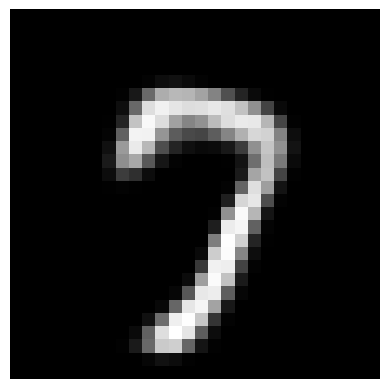

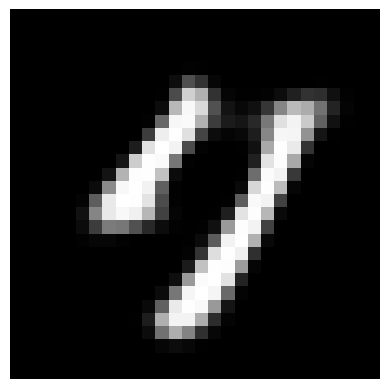

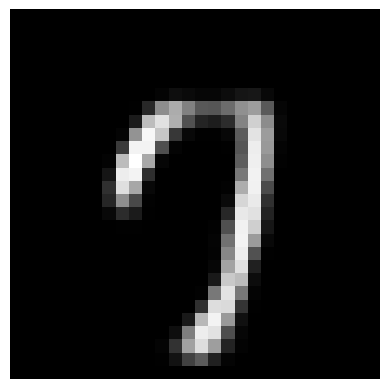

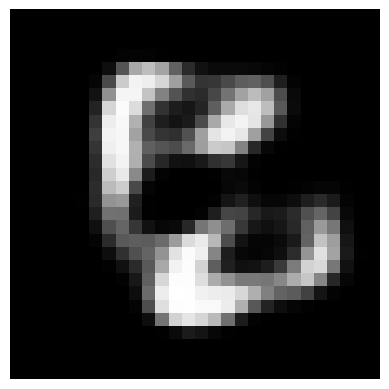

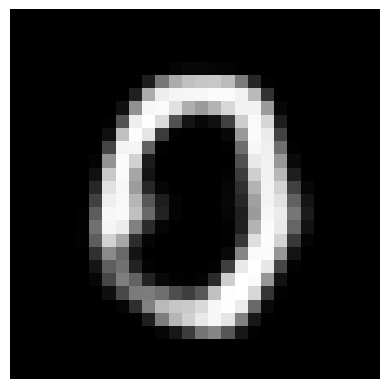

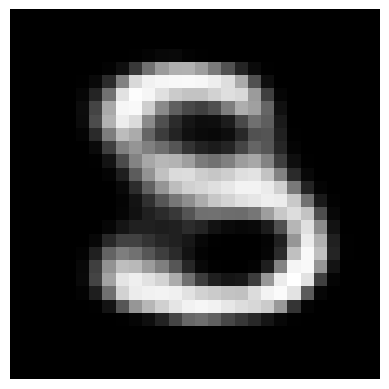

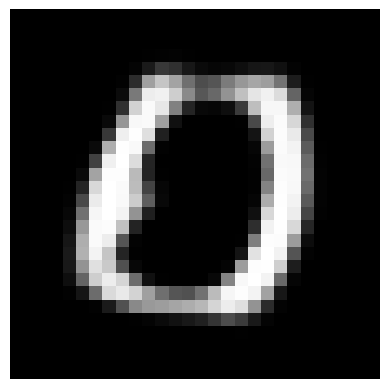

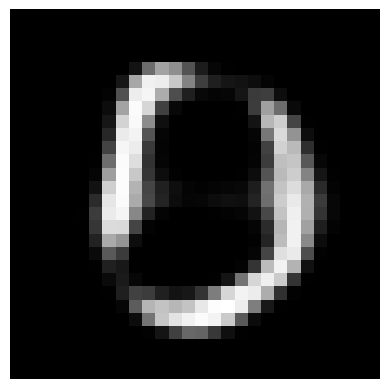

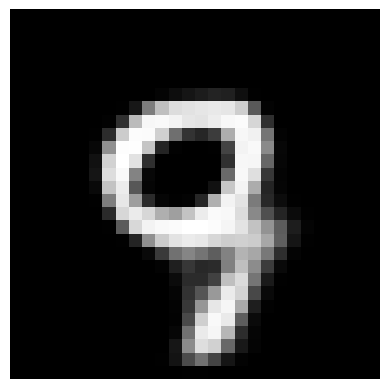

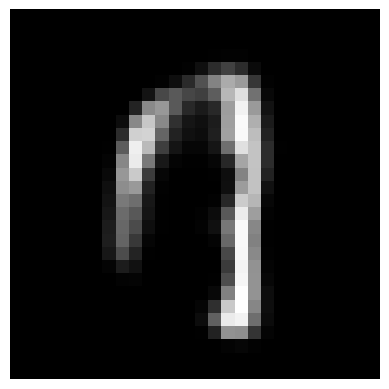

In [ ]:
#Скорректируем случайные вектора с учетом вычесленных статистик
z_adjusted = z_torch * std + mean

autoencoder.eval()
with torch.no_grad():
    decoded = autoencoder.decode(z_adjusted)
for i in range(decoded.shape[0]):
    img = decoded[i].cpu().permute(1, 2, 0).numpy()
    img /= 255.
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
autoencoder.eval()
latents = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        mu, _ = autoencoder.encode(x)
        mu_flat = mu.view(x.size(0), -1).cpu().numpy()

        latents.append(mu_flat)
        labels.append(y.cpu().numpy())

latents = np.vstack(latents)
labels = np.concatenate(labels)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(latents)

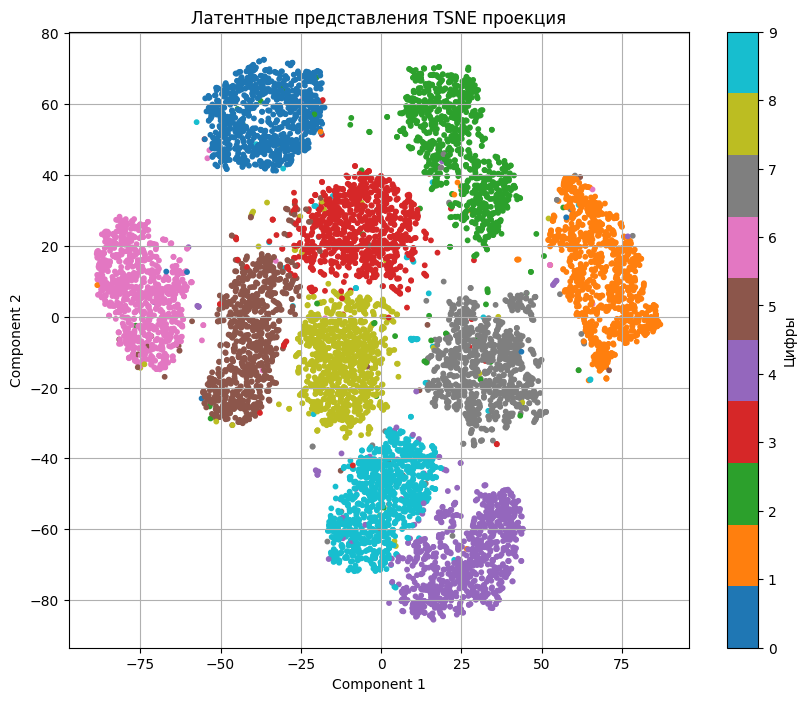

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10), label='Цифры')
plt.title("Латентные представления TSNE проекция")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

Что вы думаете о виде латентного представления?

В латентном представлении цифры 4 и 9 близки по форме, что похоже на правду.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=3), #28 -> 26
            nn.ReLU(),
            nn.Conv2d(32, 16,  kernel_size=3), #26-> 24
            nn.ReLU(),
            nn.Conv2d(16, 8,  kernel_size=3), #24 -> 22

        )

        # Отдельные "хвосты" для mu и logsigma
        self.mu_head = nn.Conv2d(8, 4, kernel_size=3) # 22 -> 20
        self.logsigma_head = nn.Conv2d(8, 4, kernel_size=3) # 22 -> 20

        # Размерность латентного пространства
        self.latent_dim = 4 * 20 * 20  # 4 канала, 20x20 пространство

        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(14, 8, kernel_size=3), # 20 -> 22
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(8, 16, kernel_size=3), # 22 -> 24
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(16, 32, kernel_size=3), # 24 -> 26
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(32, 1, kernel_size=3), # 26 -> 28
            nn.Sigmoid()
        )


    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве возвращаемых переменных -- mu, logsigma и класс картинки>
        class_num_oh = F.one_hot(class_num, 10).float()
        class_img = class_num_oh.view(class_num_oh.shape[0], 10, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])  # [B, 10, 28, 28]
        x_plus_class = torch.cat([x, class_img], dim=1)  # [B, 1+10, 28, 28]
        x_plus_class = self.encoder(x_plus_class)
        mu = self.mu_head(x_plus_class)
        logsigma = self.logsigma_head(x_plus_class)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma
            # Сохраняем форму тензоров
            batch_size, channels, height, width = mu.shape

            # Reshape для удобства операций
            mu_flat = mu.view(batch_size, -1)
            logsigma_flat = logsigma.view(batch_size, -1)

            # Семплирование
            std = torch.exp(0.5 * logsigma_flat)
            eps = torch.randn_like(std)
            sample_flat = mu_flat + (eps * std)

            # Возвращаем к исходной форме
            sample = sample_flat.view(batch_size, channels, height, width)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        # реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction
        class_num_oh = F.one_hot(class_num, 10).float()
        class_img = class_num_oh.view(class_num_oh.shape[0], 10, 1, 1).expand(-1, -1, z.shape[2], z.shape[3])  # [B, 10, H, W]
        z_plus_class = torch.cat([z, class_img], dim=1)  # [B, latent_channels+10, H, W]
        reconstruction = self.decoder(z_plus_class)
        return reconstruction

    def forward(self, x, class_num):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        # encoding
        mu, logsigma = self.encode(x, class_num)

        #sampling
        z = self.gaussian_sampler(mu, logsigma)

        # decoding

        reconstruction =  self.decode(z, class_num)


        return reconstruction, mu, logsigma

Обучение

In [ ]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
cvae = CVAE()
cvae = cvae.to(device)


optimizer = optimizer = torch.optim.Adam(cvae.parameters(), lr=0.001)# <Ваш любимый оптимизатор>

cuda:0


In [ ]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    cvae.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        x, class_num = batch[0], batch[1]
        reconstruction, mu, logsigma = cvae(x.to(device),class_num.to(device))
        loss = criterion(x.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    cvae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          x, class_num =  batch[0], batch[1]
          reconstruction, mu, logsigma = cvae(x.to(device), class_num.to(device))
          loss = criterion(x.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-135-43dc31ac6a36>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

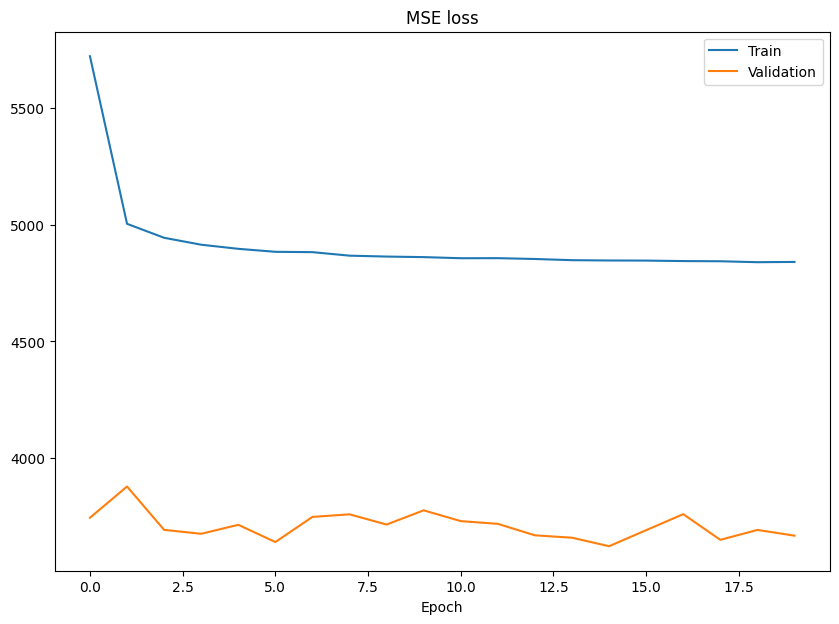

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')


plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
channels, height, width = 4, 20, 20
z = np.random.randn(10, channels, height, width)
z_torch = torch.from_numpy(z).float().to(device)
z_torch.shape

torch.Size([10, 4, 20, 20])

In [ ]:
class_num_oh = F.one_hot(torch.tensor(5), 10).float().to(device)
class_img = class_num_oh.view(-1, 10, 1, 1).expand(10, 10, 20, 20)
#class_img = class_num_oh.view(class_num_oh.shape[0], 10, 1, 1)#.expand(-1, -1, z_torch.shape[2], z_torch.shape[3])  # [B, 10, H, W]
z_plus_class = torch.cat([z_torch, class_img], dim=1)  # [B, latent_channels+10, H, W]


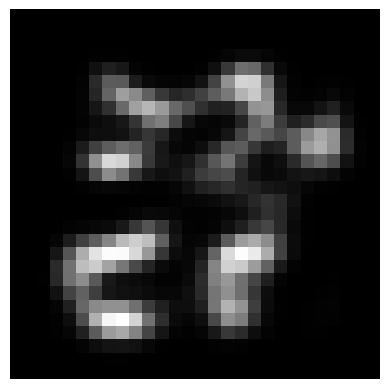

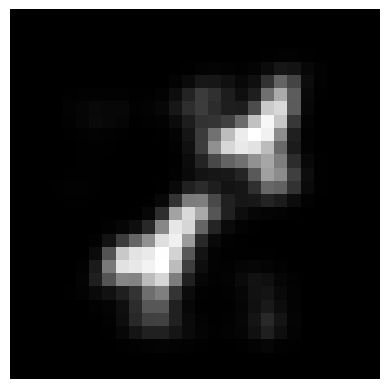

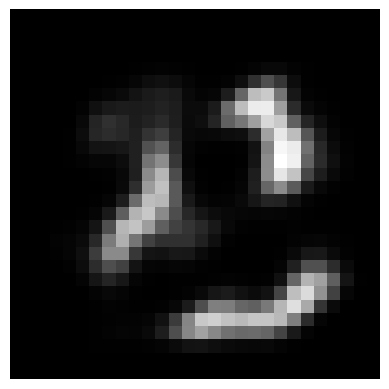

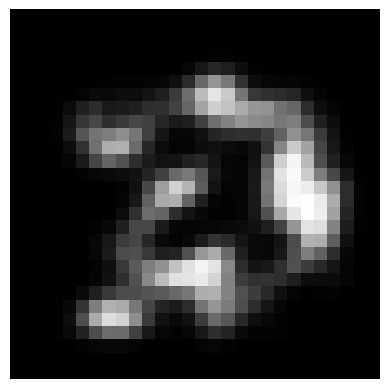

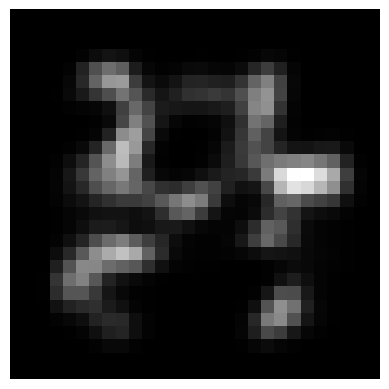

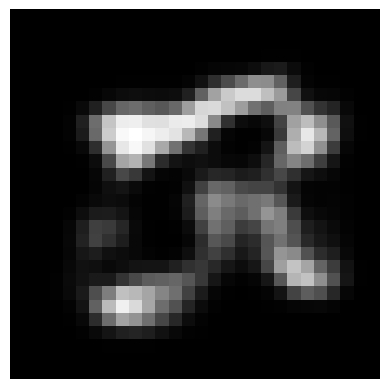

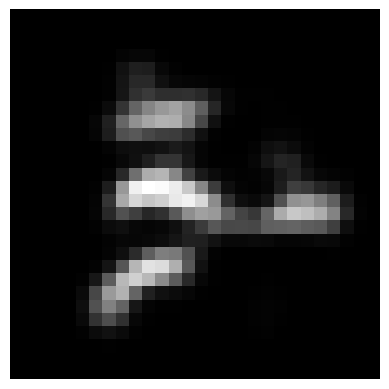

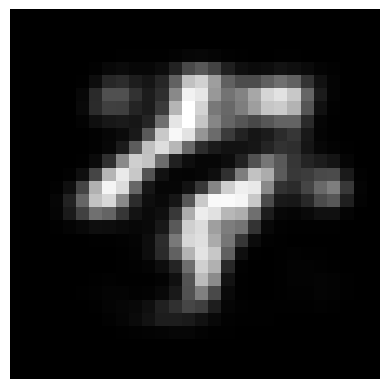

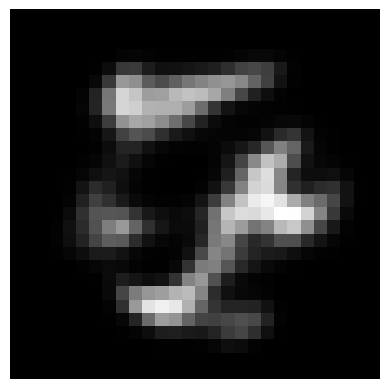

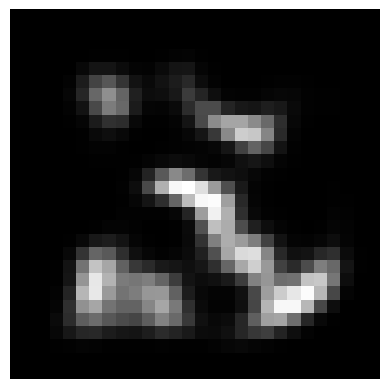

In [ ]:
#подаем сгененрированные вектора на вход декодеру
cvae.eval()
with torch.no_grad():
    decoded = cvae.decoder(z_plus_class)

for i in range(decoded.shape[0]):
    img = decoded[i][0]
    img = img.cpu().numpy()
    img /= 255.
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# прогоним через энкодер 20 изображений и вычислим среднее и среднеквадратическое отклонение по батчу получившихся латентных векторов
all_latents = []
cvae.eval()
for pair in zip(first_batch[0], first_batch[1]):
    #print(pair)
    val_img = pair[0]
    class_num = pair[1]
    class_num = class_num.unsqueeze(0)
    val_img = val_img.unsqueeze(0) # (1, 28, 28) -> (1, 1, 28, 28)
    val_img = val_img.float()


    reconstruction, mu, logsigma = cvae(val_img.to(device), class_num.to(device))
    latent = cvae.gaussian_sampler(mu, logsigma)
    all_latents.append(latent)

In [ ]:
all_latents = torch.cat(all_latents, dim=0)

In [ ]:
all_latents.shape

torch.Size([20, 4, 20, 20])

In [ ]:
mean = all_latents.mean(dim=0)
std = all_latents.std(dim=0)
print(mean.shape, std.shape)

torch.Size([4, 20, 20]) torch.Size([4, 20, 20])


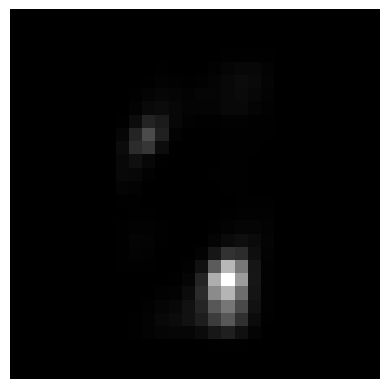

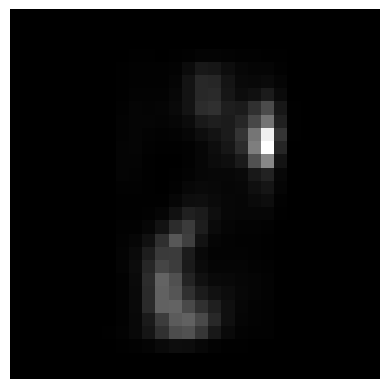

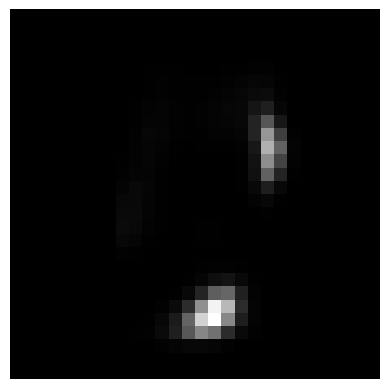

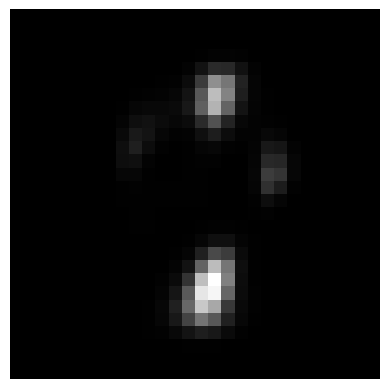

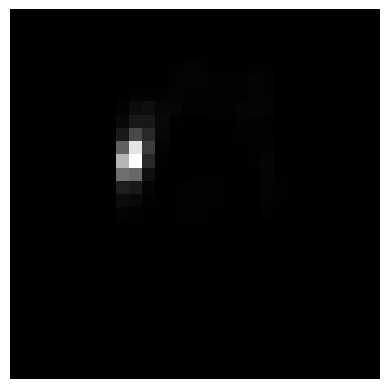

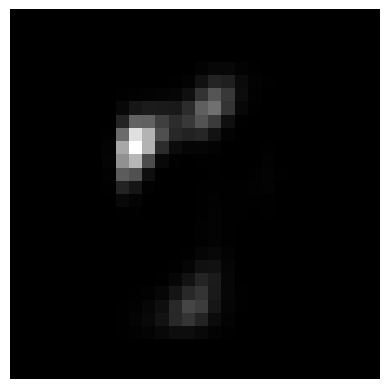

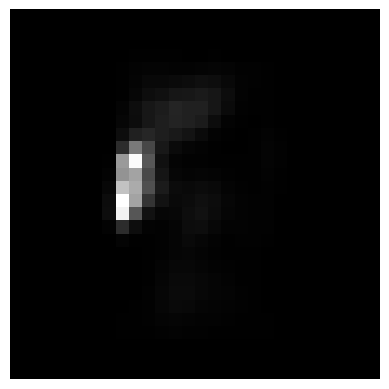

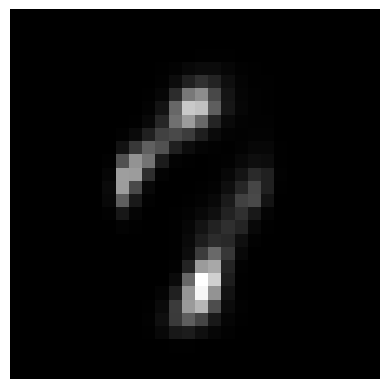

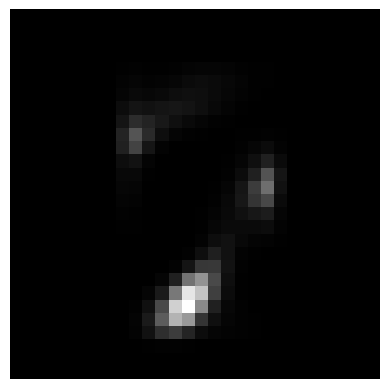

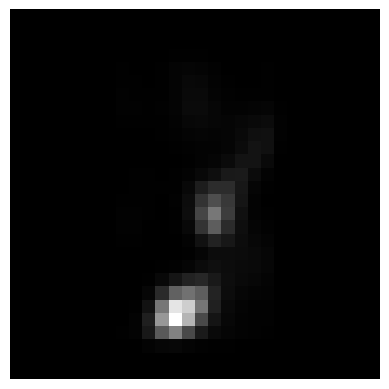

In [ ]:
#Скорректируем случайные вектора с учетом вычесленных статистик
z_adjusted = z_torch * std + mean
class_num_oh = F.one_hot(torch.tensor(1), 10).float()
class_img = class_num_oh.view(-1, 10, 1, 1).expand(10, 10, 20, 20).to(device)
#class_img = class_num_oh.view(class_num_oh.shape[0], 10, 1, 1)#.expand(-1, -1, z_torch.shape[2], z_torch.shape[3])  # [B, 10, H, W]
z_plus_class = torch.cat([z_adjusted, class_img], dim=1)  # [B, latent_channels+10, H, W]

#подаем скорректированные вектора на вход декодеру
cvae.eval()
with torch.no_grad():
    decoded = cvae.decoder(z_plus_class)

for i in range(decoded.shape[0]):
    img = decoded[i][0]
    img = img.cpu().numpy()
    img /= 255.
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
cvae.eval()
latents = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        mu, _ = cvae.encode(x,y)
        mu_flat = mu.view(x.size(0), -1).cpu().numpy()

        latents.append(mu_flat)
        labels.append(y.cpu().numpy())

latents = np.vstack(latents)
labels = np.concatenate(labels)

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(latents)

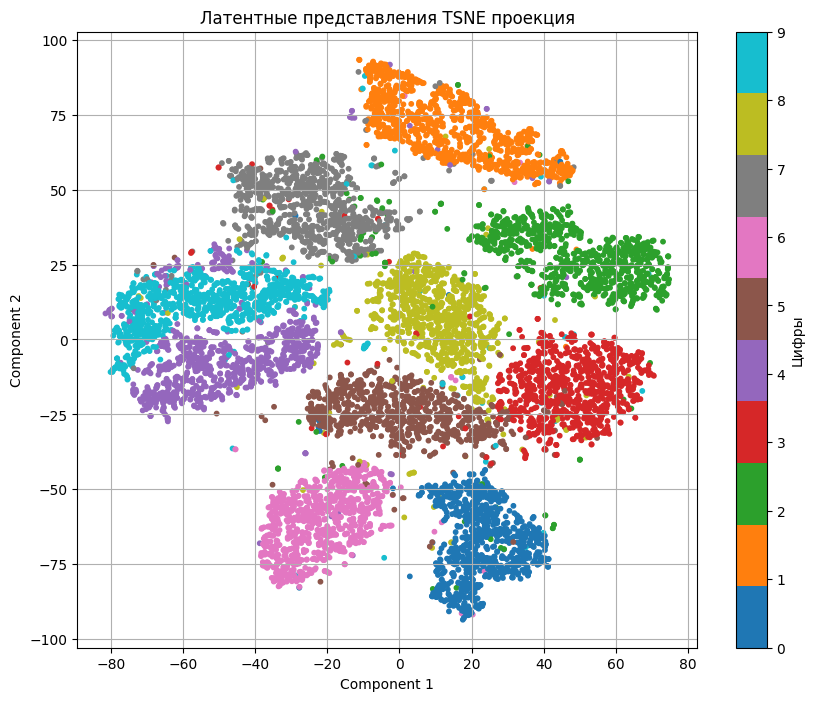

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10), label='Цифры')
plt.title("Латентные представления TSNE проекция")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Распределение кластеров по компонентам отличается, но кластеры, соответствующие похожим цифрам 4 и 9 пересекаются.

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

NameError: name 'X' is not defined

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>